In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import numpy as np # Added for safety if needed later

# --- CORRECTED CODE ---

# Simple approach - go up two levels from notebooks folder
PROJECT_ROOT = Path.cwd().parent.parent
DATA_DIR = PROJECT_ROOT / 'data'/'raw'
data_file = DATA_DIR / 'heart disease.parquet'

# Check if file exists
if not data_file.is_file():
    print(f"Error: Dataset not found: {data_file}")
    print(f"Project root: {PROJECT_ROOT}")
    print(f"Data directory: {DATA_DIR}")
   
    raise FileNotFoundError(f"FATAL: Required dataset not found at {data_file}. Please verify path.")

# Load dataset
try:
    df = pd.read_parquet(data_file)
    print(f"Dataset loaded: {data_file}")
except Exception as e:
    print(f"Error reading file: {e}")
    # CORRECTED: Raise a standard Exception if reading fails
    raise IOError(f"FATAL: Error reading Parquet file: {e}")

# Drop 'id' column if present
if 'id' in df.columns:
    df = df.drop(columns='id')

# Display basic info
print(f"Shape: {df.shape}")
print(f"Columns: {', '.join(df.columns)}")
print(f"Missing values: {df.isna().sum().sum()}")
print("\nFirst 5 rows:")
print(df.head())

Dataset loaded: p:\projects\heart_disease_prediction\data\raw\heart disease.parquet
Shape: (70000, 12)
Columns: age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio
Missing values: 0

First 5 rows:
     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [2]:
# drop the duplicates records
df=df.drop_duplicates().reset_index(drop=True)
df.shape

(69976, 12)

In [3]:
# Show columns names
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [4]:
# Robust column renaming with validation
column_mapping = {
    'age': 'Age',
    'gender': 'Sex',
    'height': 'Height',
    'weight': 'Weight',
    'ap_hi': 'Systolic_BP',
    'ap_lo': 'Diastolic_BP',
    'cholesterol': 'Cholesterol_Level',
    'gluc': 'Glucose_Level',
    'smoke': 'Smoking_Status',
    'alco': 'Alcohol_Intake',
    'active': 'Physical_Activity',
    'cardio': 'target'
}
df = df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns})
df.columns  # Show column names after renaming

Index(['Age', 'Sex', 'Height', 'Weight', 'Systolic_BP', 'Diastolic_BP',
       'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
       'Alcohol_Intake', 'Physical_Activity', 'target'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                69976 non-null  int64  
 1   Sex                69976 non-null  int64  
 2   Height             69976 non-null  int64  
 3   Weight             69976 non-null  float64
 4   Systolic_BP        69976 non-null  int64  
 5   Diastolic_BP       69976 non-null  int64  
 6   Cholesterol_Level  69976 non-null  int64  
 7   Glucose_Level      69976 non-null  int64  
 8   Smoking_Status     69976 non-null  int64  
 9   Alcohol_Intake     69976 non-null  int64  
 10  Physical_Activity  69976 non-null  int64  
 11  target             69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [6]:
# Create mapping dictionaries
mapping_dict = {
    'Sex': {1: 'Male', 2: 'Female'},
    'Cholesterol_Level': {1: 'Normal', 2: 'Borderline High', 3: 'High'},
    'Glucose_Level': {1: 'Normal', 2: 'Prediabetes', 3: 'Diabetes'},
    'Smoking_Status': {0: 'Non-Smoker', 1: 'Smoker'},
    'Alcohol_Intake': {0: 'No/Rarely', 1: 'Yes/Regularly'},
    'Physical_Activity': {0: 'Inactive/Low', 1: 'Active'},
    'target': {0: 'No Disease', 1: 'Disease'}
}

# Apply mappings IN-PLACE to the original columns and set the correct dtype
for col, mapping in mapping_dict.items():
    if col in df.columns:
        # Update the column directly
        df[col] = df[col].map(mapping)
        # Set the column to be a categorical dtype
        df[col] = df[col].astype('category')

print("✓ Mappings applied in-place and categorical dtypes set")

# Define other column type conversions
categorical_cols = ['Sex','target','Cholesterol_Level','Glucose_Level','Smoking_Status',
                    'Alcohol_Intake', 'Physical_Activity']  

float_cols = ['Height', 'Weight']

num_cols = ['Age','Systolic_BP', 'Diastolic_BP']

# Convert categorical columns (already done above, but ensure they're categorical)
for col in categorical_cols:
    if col in df.columns and col not in mapping_dict.keys():  # Only if not already processed
        df[col] = df[col].astype('category')
        print(f"Converted {col} to category type")

# Convert float columns - handle missing values properly
for col in float_cols:
    if col in df.columns:
        # 'coerce' will turn any non-numeric values into NaN (missing)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # No need for astype(float) since to_numeric already returns float
        print(f"Converted {col} to float type")

# Convert integer columns - handle NaN values correctly
for col in num_cols:
    if col in df.columns:
        # First convert to numeric with coercion for invalid values
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Then convert to integer, but only for non-NaN values
        # This avoids the error when trying to convert NaN to int
        mask = df[col].notna()
        if mask.all():
            df[col] = df[col].astype(int)
        else:
            # Keep NaN values as is, convert only valid values to int
            df.loc[mask, col] = df.loc[mask, col].astype(int)
        print(f"Converted {col} to integer type (with NaN handling)")

# Print unique value counts for all categorical columns
print("\n" + "="*50)
print("UNIQUE VALUE COUNTS FOR CATEGORICAL COLUMNS")
print("="*50)

all_categorical_cols = list(mapping_dict.keys()) + [col for col in categorical_cols if col not in mapping_dict.keys()]

for col in all_categorical_cols:
    if col in df.columns and df[col].dtype.name == 'category':
        print(f"\n{col}:")
        value_counts = df[col].value_counts(dropna=False)
        for value, count in value_counts.items():
            print(f"  {value}: {count}")
        print(f"  Total unique values: {len(value_counts)}")

df.info()

✓ Mappings applied in-place and categorical dtypes set
Converted Height to float type
Converted Weight to float type
Converted Age to integer type (with NaN handling)
Converted Systolic_BP to integer type (with NaN handling)
Converted Diastolic_BP to integer type (with NaN handling)

UNIQUE VALUE COUNTS FOR CATEGORICAL COLUMNS

Sex:
  Male: 45509
  Female: 24467
  Total unique values: 2

Cholesterol_Level:
  Normal: 52361
  Borderline High: 9549
  High: 8066
  Total unique values: 3

Glucose_Level:
  Normal: 59455
  Diabetes: 5331
  Prediabetes: 5190
  Total unique values: 3

Smoking_Status:
  Non-Smoker: 63807
  Smoker: 6169
  Total unique values: 2

Alcohol_Intake:
  No/Rarely: 66212
  Yes/Regularly: 3764
  Total unique values: 2

Physical_Activity:
  Active: 56241
  Inactive/Low: 13735
  Total unique values: 2

target:
  No Disease: 35004
  Disease: 34972
  Total unique values: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 colum

In [7]:
df.describe()

,Age,Height,Weight,Systolic_BP,Diastolic_BP
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,164.359152,74.208519,128.820453,96.636261
std,2467.374620,8.211218,14.397211,154.037729,188.504581
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


performing validation primarily by considering these specific, impossible values from your raw data summary:

* **For `Systolic_BP`:** The `min` of **-150** and the `max` of **16,020**.
* **For `Diastolic_BP`:** The `min` of **-70** and the `max` of **11,000**.
* **For `Height_mt`:** The `min` of **0.55**.
* **For `Weight`:** The `min` of **10**.

These values are physiologically impossible and represent clear data errors that must be corrected before any analysis can be done.

### Data Preprocessing: Clinical Range Validation and Correction

### BloodPressure cleaning

In [8]:
import pandas as pd
import numpy as np

# ==============================================================
# BLOOD PRESSURE CLEANING (Systolic_BP & Diastolic_BP ONLY)
# ==============================================================

systolic_col, diastolic_col = 'Systolic_BP', 'Diastolic_BP'

if systolic_col in df.columns and diastolic_col in df.columns:
    
    print("="*75)
    print(" BLOOD PRESSURE CLEANING PIPELINE")
    print("="*75)
    
    print(f"\n[INITIAL STATE]")
    print(f"  Systolic range: {df[systolic_col].min():.0f} - {df[systolic_col].max():.0f} mmHg")
    print(f"  Diastolic range: {df[diastolic_col].min():.0f} - {df[diastolic_col].max():.0f} mmHg")
    print(f"  Systolic nulls: {df[systolic_col].isna().sum()}")
    print(f"  Diastolic nulls: {df[diastolic_col].isna().sum()}")
    
    # STEP 1: Convert to numeric
    df[systolic_col] = pd.to_numeric(df[systolic_col], errors='coerce')
    df[diastolic_col] = pd.to_numeric(df[diastolic_col], errors='coerce')
    print(f"\n[STEP 1] ✓ Converted to numeric")
    
    # STEP 2: Remove negative values
    neg_sys = (df[systolic_col] < 0) & df[systolic_col].notna()
    neg_dia = (df[diastolic_col] < 0) & df[diastolic_col].notna()
    df.loc[neg_sys, systolic_col] = np.nan
    df.loc[neg_dia, diastolic_col] = np.nan
    print(f"[STEP 2] Removed {neg_sys.sum()} negative systolic, {neg_dia.sum()} negative diastolic")
    
    # STEP 3: Fix magnitude errors
    # 3a. Extreme typos (≥1000) → ÷10
    sys_extreme = (df[systolic_col] >= 1000) & df[systolic_col].notna()
    dia_extreme = (df[diastolic_col] >= 1000) & df[diastolic_col].notna()
    
    if sys_extreme.any():
        fixable_sys = sys_extreme & ((df[systolic_col] / 10).between(70, 250))
        df.loc[fixable_sys, systolic_col] /= 10
        df.loc[sys_extreme & ~fixable_sys, systolic_col] = np.nan
    
    if dia_extreme.any():
        fixable_dia = dia_extreme & ((df[diastolic_col] / 10).between(40, 150))
        df.loc[fixable_dia, diastolic_col] /= 10
        df.loc[dia_extreme & ~fixable_dia, diastolic_col] = np.nan
    
    # 3b. Decimal errors (300-999) → ÷10
    sys_dec = df[systolic_col].between(300, 999)
    dia_dec = df[diastolic_col].between(300, 999)
    
    if sys_dec.any():
        fixable_sys_dec = sys_dec & ((df[systolic_col] / 10).between(70, 150))
        df.loc[fixable_sys_dec, systolic_col] /= 10
        df.loc[sys_dec & ~fixable_sys_dec, systolic_col] = np.nan
    
    if dia_dec.any():
        fixable_dia_dec = dia_dec & ((df[diastolic_col] / 10).between(40, 90))
        df.loc[fixable_dia_dec, diastolic_col] /= 10
        df.loc[dia_dec & ~fixable_dia_dec, diastolic_col] = np.nan
    
    # 3c. Single digit (1-9) → ×10
    sys_single = df[systolic_col].between(1, 9)
    dia_single = df[diastolic_col].between(1, 9)
    
    if sys_single.any():
        fixable_sys_single = sys_single & ((df[systolic_col] * 10).between(70, 90))
        df.loc[fixable_sys_single, systolic_col] *= 10
        df.loc[sys_single & ~fixable_sys_single, systolic_col] = np.nan
    
    if dia_single.any():
        fixable_dia_single = dia_single & ((df[diastolic_col] * 10).between(40, 90))
        df.loc[fixable_dia_single, diastolic_col] *= 10
        df.loc[dia_single & ~fixable_dia_single, diastolic_col] = np.nan
    
    print(f"[STEP 3] ✓ Fixed magnitude errors")
    
    # STEP 4: Swap inverted pairs
    valid_pairs = df[systolic_col].notna() & df[diastolic_col].notna()
    swap_mask = valid_pairs & (df[systolic_col] < df[diastolic_col])
    
    if swap_mask.any():
        temp = df.loc[swap_mask, systolic_col].copy()
        df.loc[swap_mask, systolic_col] = df.loc[swap_mask, diastolic_col]
        df.loc[swap_mask, diastolic_col] = temp
        print(f"[STEP 4] Swapped {swap_mask.sum()} inverted pairs")
    else:
        print(f"[STEP 4] ✓ No inverted pairs")
    
    # STEP 5: Apply physiological limits
    sys_low = df[systolic_col].between(10, 69)
    sys_high = df[systolic_col] > 250
    dia_low = df[diastolic_col].between(10, 39)
    dia_high = df[diastolic_col] > 150
    
    df.loc[sys_low | sys_high, systolic_col] = np.nan
    df.loc[dia_low | dia_high, diastolic_col] = np.nan
    print(f"[STEP 5] Applied limits: 70-250 systolic, 40-150 diastolic")
    
    # SUMMARY
    print(f"\n{'='*75}")
    print(" CLEANING COMPLETE")
    print(f"{'='*75}")
    print(f"Systolic: {df[systolic_col].min():.0f}-{df[systolic_col].max():.0f} mmHg (mean: {df[systolic_col].mean():.1f})")
    print(f"Diastolic: {df[diastolic_col].min():.0f}-{df[diastolic_col].max():.0f} mmHg (mean: {df[diastolic_col].mean():.1f})")
    print(f"Valid pairs: {(df[systolic_col].notna() & df[diastolic_col].notna()).sum():,}")
    print(f"{'='*75}\n")

else:
    print("❌ Error: Systolic_BP and/or Diastolic_BP columns not found")


 BLOOD PRESSURE CLEANING PIPELINE

[INITIAL STATE]
  Systolic range: -150 - 16020 mmHg
  Diastolic range: -70 - 11000 mmHg
  Systolic nulls: 0
  Diastolic nulls: 0

[STEP 1] ✓ Converted to numeric
[STEP 2] Removed 7 negative systolic, 1 negative diastolic
[STEP 3] ✓ Fixed magnitude errors
[STEP 4] Swapped 277 inverted pairs
[STEP 5] Applied limits: 70-250 systolic, 40-150 diastolic

 CLEANING COMPLETE
Systolic: 70-240 mmHg (mean: 127.0)
Diastolic: 0-150 mmHg (mean: 81.6)
Valid pairs: 69,713



* even after cleaning also diastolic bp still have errors which will solved at once along with other
  numericals at once 
* mice imputation will be applied

### Height cleaning

In [9]:
import pandas as pd
import numpy as np

# ==============================================================
# HEIGHT CLEANING (VALIDATION ONLY)
# ==============================================================
height_col = 'Height'

if height_col in df.columns:
    
    print("="*70)
    print(" HEIGHT CLEANING PIPELINE")
    print("="*70)
    
    print(f"\n[INITIAL STATE]")
    print(f"  Height range: {df[height_col].min():.1f} - {df[height_col].max():.1f}")
    print(f"  Height nulls: {df[height_col].isna().sum()}")
    
    # STEP 1: Convert to numeric
    df[height_col] = pd.to_numeric(df[height_col], errors='coerce')
    
    # STEP 2: Remove negative and zero values
    print(f"\n[STEP 1: Removing Invalid Values]")
    negative_or_zero = df[height_col] <= 0
    df.loc[negative_or_zero, height_col] = np.nan
    print(f"  Removed {negative_or_zero.sum()} height values ≤ 0")
    
    # STEP 3: Fix magnitude errors
    print(f"\n[STEP 2: Fixing Height Magnitude Errors]")
    
    # Heights in METERS (1.0 - 2.5 m) → convert to cm
    # CORRECTED: Only values between 1.0 and 2.5 are likely meters
    meter_mask = df[height_col].between(1.0, 2.5)
    if meter_mask.any():
        df.loc[meter_mask, height_col] *= 100
        print(f"  Converted {meter_mask.sum()} heights from meters to cm (× 100)")
    else:
        print(f"  ✓ No heights in meters found")
    
    # Heights in MM (1000-2500 mm) → convert to cm
    # CORRECTED: Check for mm range (1000-2500)
    mm_mask = df[height_col].between(1000, 2500)
    if mm_mask.any():
        df.loc[mm_mask, height_col] /= 10
        print(f"  Converted {mm_mask.sum()} heights from mm to cm (÷ 10)")
    else:
        print(f"  ✓ No heights in mm found")
    
    # Decimal point errors (300-999) → likely should be 30.0-99.9 cm, but invalid
    # OR could be typos like 1650 meant to be 165
    decimal_errors = df[height_col].between(300, 999)
    if decimal_errors.any():
        # Check if dividing by 10 gives valid range
        fixable = decimal_errors & ((df[height_col] / 10).between(130, 230))
        df.loc[fixable, height_col] /= 10
        df.loc[decimal_errors & ~fixable, height_col] = np.nan
        print(f"  Fixed {fixable.sum()} decimal errors (300-999 → ÷10)")
        print(f"  Nullified {(decimal_errors & ~fixable).sum()} unfixable values")
    
    # Single/double digit errors (10-129) → likely invalid or data entry errors
    too_small = df[height_col].between(10, 129)
    if too_small.any():
        df.loc[too_small, height_col] = np.nan
        print(f"  Removed {too_small.sum()} suspiciously small heights (10-129 cm)")
    
    # STEP 4: Apply physiological limits
    print(f"\n[STEP 3: Applying Physiological Limits]")
    
    # Valid adult height range: 130-230 cm (4'3" to 7'7")
    too_short = (df[height_col] < 130) & df[height_col].notna()
    too_tall = df[height_col] > 230
    
    df.loc[too_short, height_col] = np.nan
    df.loc[too_tall, height_col] = np.nan
    
    print(f"  Removed {too_short.sum()} heights < 130 cm")
    print(f"  Removed {too_tall.sum()} heights > 230 cm")
    
    # SUMMARY
    print(f"\n{'='*70}")
    print(" CLEANING SUMMARY")
    print(f"{'='*70}")
    
    height_valid = df[height_col].notna()
    
    print(f"\nFinal Statistics:")
    if height_valid.any():
        print(f"  Height range: {df[height_col].min():.1f} - {df[height_col].max():.1f} cm")
        print(f"  Height mean: {df[height_col].mean():.1f} cm")
        print(f"  Height median: {df[height_col].median():.1f} cm")
    else:
        print("  No valid height values remain")
    
    print(f"\nMissing Values:")
    print(f"  Height nulls: {df[height_col].isna().sum()} ({df[height_col].isna().mean()*100:.1f}%)")
    
    print(f"\nData Quality:")
    print(f"  Valid records: {height_valid.sum()} ({height_valid.mean()*100:.1f}%)")
    
    if height_valid.any():
        # Final validation check
        if df[height_col].min() >= 130 and df[height_col].max() <= 230:
            print(f"\n✅ All heights within clinical range (130-230 cm)!")
        else:
            print(f"\n⚠ Some extreme values present")
    
    print(f"\n{'='*70}\n")

else:
    print("❌ Error: Height column not found in DataFrame")


 HEIGHT CLEANING PIPELINE

[INITIAL STATE]
  Height range: 55.0 - 250.0
  Height nulls: 0

[STEP 1: Removing Invalid Values]
  Removed 0 height values ≤ 0

[STEP 2: Fixing Height Magnitude Errors]
  ✓ No heights in meters found
  ✓ No heights in mm found
  Removed 92 suspiciously small heights (10-129 cm)

[STEP 3: Applying Physiological Limits]
  Removed 0 heights < 130 cm
  Removed 1 heights > 230 cm

 CLEANING SUMMARY

Final Statistics:
  Height range: 130.0 - 207.0 cm
  Height mean: 164.4 cm
  Height median: 165.0 cm

Missing Values:
  Height nulls: 93 (0.1%)

Data Quality:
  Valid records: 69883 (99.9%)

✅ All heights within clinical range (130-230 cm)!




### Weight cleaning

In [10]:
import pandas as pd
import numpy as np

# ==============================================================
# WEIGHT CLEANING (VALIDATION ONLY)
# ==============================================================
weight_col = 'Weight'

if weight_col in df.columns:
    
    print("="*70)
    print(" WEIGHT CLEANING PIPELINE")
    print("="*70)
    
    print(f"\n[INITIAL STATE]")
    print(f"  Weight range: {df[weight_col].min():.1f} - {df[weight_col].max():.1f} kg")
    print(f"  Weight nulls: {df[weight_col].isna().sum()}")
    
    # STEP 1: Convert to numeric
    df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')
    
    # STEP 2: Remove negative and zero values
    print(f"\n[STEP 1: Removing Invalid Values]")
    negative_or_zero = df[weight_col] <= 0
    df.loc[negative_or_zero, weight_col] = np.nan
    print(f"  Removed {negative_or_zero.sum()} weight values ≤ 0")
    
    # STEP 3: Fix magnitude errors
    print(f"\n[STEP 2: Fixing Weight Magnitude Errors]")
    
    # Weights > 500 kg (typos with extra digits)
    large_weight = df[weight_col] > 500
    if large_weight.any():
        fixable = large_weight & ((df[weight_col] / 10).between(30, 300))
        df.loc[fixable, weight_col] /= 10
        df.loc[large_weight & ~fixable, weight_col] = np.nan
        print(f"  Fixed {fixable.sum()} large weights (÷10)")
        print(f"  Nullified {(large_weight & ~fixable).sum()} unfixable large weights")
    else:
        print(f"  ✓ No large weight typos found")
    
    # Decimal point errors (301-999) → divide by 10
    decimal_errors = df[weight_col].between(301, 999)
    if decimal_errors.any():
        fixable_dec = decimal_errors & ((df[weight_col] / 10).between(30, 99))
        df.loc[fixable_dec, weight_col] /= 10
        df.loc[decimal_errors & ~fixable_dec, weight_col] = np.nan
        print(f"  Fixed {fixable_dec.sum()} decimal errors (301-999 → ÷10)")
        print(f"  Nullified {(decimal_errors & ~fixable_dec).sum()} unfixable values")
    
    # Single digit weights (1-9) → likely data entry errors
    single_digit = df[weight_col].between(1, 9)
    if single_digit.any():
        # Could be missing zero (e.g., 7 → 70), but risky to assume
        df.loc[single_digit, weight_col] = np.nan
        print(f"  Removed {single_digit.sum()} single digit weights (1-9 kg)")
    
    # STEP 4: Apply physiological limits
    print(f"\n[STEP 3: Applying Physiological Limits]")
    
    # Weight limits: 30-300 kg (adults)
    too_light = (df[weight_col] < 30) & df[weight_col].notna()
    too_heavy = df[weight_col] > 300
    
    df.loc[too_light, weight_col] = np.nan
    df.loc[too_heavy, weight_col] = np.nan
    
    print(f"  Removed {too_light.sum()} weights < 30 kg")
    print(f"  Removed {too_heavy.sum()} weights > 300 kg")
    
    # SUMMARY
    print(f"\n{'='*70}")
    print(" CLEANING SUMMARY")
    print(f"{'='*70}")
    
    weight_valid = df[weight_col].notna()
    
    print(f"\nFinal Statistics:")
    if weight_valid.any():
        print(f"  Weight range: {df[weight_col].min():.1f} - {df[weight_col].max():.1f} kg")
        print(f"  Weight mean: {df[weight_col].mean():.1f} kg")
        print(f"  Weight median: {df[weight_col].median():.1f} kg")
    else:
        print("  No valid weight values remain")
    
    print(f"\nMissing Values:")
    print(f"  Weight nulls: {df[weight_col].isna().sum()} ({df[weight_col].isna().mean()*100:.1f}%)")
    
    print(f"\nData Quality:")
    print(f"  Valid records: {weight_valid.sum()} ({weight_valid.mean()*100:.1f}%)")
    
    if weight_valid.any():
        if df[weight_col].min() >= 30 and df[weight_col].max() <= 300:
            print(f"\n✅ All weights within clinical range (30-300 kg)!")
        else:
            print(f"\n⚠ Some extreme values present")
    
    print(f"\n{'='*70}\n")

else:
    print("❌ Error: Weight column not found in DataFrame")


 WEIGHT CLEANING PIPELINE

[INITIAL STATE]
  Weight range: 10.0 - 200.0 kg
  Weight nulls: 0

[STEP 1: Removing Invalid Values]
  Removed 0 weight values ≤ 0

[STEP 2: Fixing Weight Magnitude Errors]
  ✓ No large weight typos found

[STEP 3: Applying Physiological Limits]
  Removed 7 weights < 30 kg
  Removed 0 weights > 300 kg

 CLEANING SUMMARY

Final Statistics:
  Weight range: 30.0 - 200.0 kg
  Weight mean: 74.2 kg
  Weight median: 72.0 kg

Missing Values:
  Weight nulls: 7 (0.0%)

Data Quality:
  Valid records: 69969 (100.0%)

✅ All weights within clinical range (30-300 kg)!




### age convertion (days -> years)

In [11]:
# One-liner conversion with min/max display
df['Age_Years'] = df['Age'] / 365.25
df['Age_Years'] = df['Age_Years'].where((df['Age_Years'] >= 0) & (df['Age_Years'] <= 120))

df= df.drop(columns='Age')

print(f"Age range: {df['Age_Years'].min():.1f} - {df['Age_Years'].max():.1f} years")

Age range: 29.6 - 64.9 years


In [12]:
df.describe()

,Height,Weight,Systolic_BP,Diastolic_BP,Age_Years
count,69883.000000,69969.000000,69942.000000,69735.000000,69976.000000
mean,164.438991,74.213885,126.963513,81.554744,53.303080
std,7.859999,14.387763,17.166399,9.797524,6.755304
min,130.000000,30.000000,70.000000,0.000000,29.563313
25%,159.000000,65.000000,120.000000,80.000000,48.361396
50%,165.000000,72.000000,120.000000,80.000000,53.943874
75%,170.000000,82.000000,140.000000,90.000000,58.390144
max,207.000000,200.000000,240.000000,150.000000,64.922656


### Filling nan values and validating again

In [13]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# ==============================================================
# MICE IMPUTATION WITH CATEGORICAL TEXT LABELS
# ==============================================================

print("="*75)
print(" MICE IMPUTATION (Preserving Categorical Text Labels)")
print("="*75)

# ==============================================================
# STEP 1: IDENTIFY COLUMN TYPES
# ==============================================================

print("\n" + "="*75)
print("STEP 1: IDENTIFYING COLUMN TYPES")
print("="*75)

# Identify categorical (text) columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nCategorical columns ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_vals = df[col].dropna().unique()
    print(f"  {col}: {list(unique_vals)[:5]}")

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns ({len(numeric_cols)}):")
print(f"  {', '.join(numeric_cols)}")

# ==============================================================
# STEP 2: CLINICAL RANGE VALIDATION
# ==============================================================

CLINICAL_RANGES = {
    'Height': (130, 230),
    'Weight': (30, 300),
    'Systolic_BP': (70, 250),
    'Diastolic_BP': (40, 150),
}

print("\n" + "="*75)
print("STEP 2: CLINICAL RANGE VALIDATION")
print("="*75)

print("\nApplying range validation...")
for col, (min_val, max_val) in CLINICAL_RANGES.items():
    if col in df.columns:
        below_min = (df[col] < min_val) & df[col].notna()
        above_max = (df[col] > max_val) & df[col].notna()
        total_invalid = below_min.sum() + above_max.sum()
        
        if total_invalid > 0:
            df.loc[below_min | above_max, col] = np.nan
            print(f"  {col}: Set {total_invalid} out-of-range to NaN "
                  f"({below_min.sum()} < {min_val}, {above_max.sum()} > {max_val})")
        else:
            print(f"  {col}: ✓ All in range")

# ==============================================================
# STEP 3: ENCODE CATEGORICAL COLUMNS FOR MICE
# ==============================================================

print("\n" + "="*75)
print("STEP 3: TEMPORARILY ENCODING CATEGORICAL COLUMNS")
print("="*75)

# Store encoders and create encoded columns
label_encoders = {}
encoded_col_names = []

if len(categorical_cols) > 0:
    print("\nEncoding categorical text to numbers (temporary)...")
    
    for col in categorical_cols:
        le = LabelEncoder()
        non_null_mask = df[col].notna()
        
        if non_null_mask.sum() > 0:
            le.fit(df.loc[non_null_mask, col])
            encoded_col = col + '_encoded'
            df[encoded_col] = np.nan
            df.loc[non_null_mask, encoded_col] = le.transform(df.loc[non_null_mask, col])
            
            label_encoders[col] = le
            encoded_col_names.append(encoded_col)
            
            print(f"  {col} → {encoded_col}: {list(le.classes_)}")
    
    print(f"\n✓ Created {len(encoded_col_names)} encoded columns")
else:
    print("\n✓ No categorical columns to encode")

# ==============================================================
# STEP 4: PREPARE ALL COLUMNS FOR MICE
# ==============================================================

print("\n" + "="*75)
print("STEP 4: PREPARING FULL DATASET FOR MICE")
print("="*75)

# All columns for MICE
all_cols_for_mice = numeric_cols + encoded_col_names

print(f"\nTotal columns for MICE: {len(all_cols_for_mice)}")
print(f"  - Original numeric: {len(numeric_cols)}")
print(f"  - Encoded categorical: {len(encoded_col_names)}")

# Show missing data
print("\nMissing data summary:")
missing_summary = df[all_cols_for_mice].isna().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        print(f"  {col}: {count} ({count/len(df)*100:.2f}%)")
else:
    print("  ✓ No missing values")

# ==============================================================
# STEP 5: CONFIGURE MICE CONSTRAINTS (AS ARRAYS, NOT DICTS!)
# ==============================================================

print("\n" + "="*75)
print("STEP 5: CONFIGURING MICE CONSTRAINTS")
print("="*75)

# Create min/max arrays in the SAME ORDER as all_cols_for_mice
min_values = []
max_values = []

for col in all_cols_for_mice:
    # Check if it's a clinical variable
    if col in CLINICAL_RANGES:
        min_val, max_val = CLINICAL_RANGES[col]
        min_values.append(min_val)
        max_values.append(max_val)
        print(f"  {col}: [{min_val}, {max_val}]")
    
    # Check if it's an encoded categorical
    elif col in encoded_col_names:
        original_col = col.replace('_encoded', '')
        if original_col in label_encoders:
            le = label_encoders[original_col]
            min_values.append(0)
            max_values.append(len(le.classes_) - 1)
            print(f"  {col}: [0, {len(le.classes_) - 1}]")
        else:
            min_values.append(-np.inf)
            max_values.append(np.inf)
    
    # Other columns - no constraints
    else:
        min_values.append(-np.inf)
        max_values.append(np.inf)

# Convert to numpy arrays
min_values = np.array(min_values)
max_values = np.array(max_values)

print(f"\n✓ Created constraint arrays (length: {len(min_values)})")

# ==============================================================
# STEP 6: MICE IMPUTATION
# ==============================================================

print("\n" + "="*75)
print("STEP 6: MICE IMPUTATION")
print("="*75)

print("\nConfiguring MICE imputer...")
print("  - Using ALL features (numeric + encoded categorical)")
print("  - Learning relationships across all variables")
print("  - Constraining to valid ranges")

# Create MICE imputer with ARRAY constraints
mice_imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    initial_strategy='median',
    min_value=min_values,  # ARRAY, not dict!
    max_value=max_values,  # ARRAY, not dict!
    verbose=0
)

print("\nApplying MICE imputation...")
original_missing = df[all_cols_for_mice].isna().sum().sum()

# Apply MICE
df[all_cols_for_mice] = mice_imputer.fit_transform(df[all_cols_for_mice])

print(f"✓ MICE imputation complete!")
print(f"  Imputed {original_missing} missing values")

# ==============================================================
# STEP 7: DECODE CATEGORICAL COLUMNS BACK TO TEXT
# ==============================================================

print("\n" + "="*75)
print("STEP 7: DECODING CATEGORICAL COLUMNS TO TEXT")
print("="*75)

if len(encoded_col_names) > 0:
    print("\nDecoding back to original text labels...")
    
    for col in categorical_cols:
        encoded_col = col + '_encoded'
        
        if encoded_col in df.columns and col in label_encoders:
            le = label_encoders[col]
            
            # Round to nearest integer
            df[encoded_col] = df[encoded_col].round().astype(int)
            
            # Clip to valid range
            df[encoded_col] = df[encoded_col].clip(0, len(le.classes_) - 1)
            
            # Decode back to text
            df[col] = le.inverse_transform(df[encoded_col])
            
            print(f"  {encoded_col} → {col}: {list(le.classes_)}")
            
            # Drop temporary encoded column
            df = df.drop(columns=[encoded_col])
    
    print(f"\n✓ All categorical columns decoded to text")
else:
    print("\n✓ No categorical columns to decode")

# ==============================================================
# STEP 8: POST-IMPUTATION VALIDATION
# ==============================================================

print("\n" + "="*75)
print("STEP 8: POST-IMPUTATION VALIDATION")
print("="*75)

print("\nMissing values AFTER imputation:")
total_missing = df.isna().sum().sum()
if total_missing == 0:
    print("  ✓ All missing values imputed!")
else:
    print(f"  ⚠ Remaining: {total_missing}")

print("\nValidating clinical variables:")
for col, (min_val, max_val) in CLINICAL_RANGES.items():
    if col in df.columns:
        actual_min = df[col].min()
        actual_max = df[col].max()
        in_range = (actual_min >= min_val) and (actual_max <= max_val)
        status = "✓" if in_range else "⚠"
        print(f"  {col}: {actual_min:.1f} - {actual_max:.1f} {status}")

print("\nValidating categorical variables:")
for col in categorical_cols:
    if col in df.columns:
        unique_vals = df[col].unique()
        print(f"  {col}: {list(unique_vals)}")

# ==============================================================
# STEP 9: FINAL SAFETY CLIP
# ==============================================================

print("\n" + "="*75)
print("STEP 9: FINAL SAFETY CLIP")
print("="*75)

clipped_count = 0
for col, (min_val, max_val) in CLINICAL_RANGES.items():
    if col in df.columns:
        before = df[col].copy()
        df[col] = df[col].clip(lower=min_val, upper=max_val)
        clipped = (df[col] != before).sum()
        if clipped > 0:
            print(f"  {col}: Clipped {clipped} values")
            clipped_count += clipped

if clipped_count == 0:
    print("  ✓ No clipping needed")

# ==============================================================
# FINAL SUMMARY
# ==============================================================

print("\n" + "="*75)
print(" IMPUTATION COMPLETE")
print("="*75)

print(f"\nDataset shape: {df.shape}")
print(f"Total missing values: {df.isna().sum().sum()}")

print("\nFinal statistics (clinical variables):")
clinical_cols = [col for col in CLINICAL_RANGES.keys() if col in df.columns]
if clinical_cols:
    print(df[clinical_cols].describe().round(2))

print("\nFinal distributions (categorical variables - first 4):")
for col in categorical_cols[:4]:
    if col in df.columns:
        print(f"\n{col}:")
        counts = df[col].value_counts()
        for category, count in counts.items():
            pct = count / len(df) * 100
            print(f"  {category}: {count} ({pct:.1f}%)")

print("\n✅ MICE imputation complete!")
print("✅ Categorical columns preserved as text")
print("✅ All relationships utilized for accurate imputation")
print("="*75 + "\n")

 MICE IMPUTATION (Preserving Categorical Text Labels)

STEP 1: IDENTIFYING COLUMN TYPES

Categorical columns (7):
  Sex: ['Female', 'Male']
  Cholesterol_Level: ['Normal', 'High', 'Borderline High']
  Glucose_Level: ['Normal', 'Prediabetes', 'Diabetes']
  Smoking_Status: ['Non-Smoker', 'Smoker']
  Alcohol_Intake: ['No/Rarely', 'Yes/Regularly']
  Physical_Activity: ['Active', 'Inactive/Low']
  target: ['No Disease', 'Disease']

Numeric columns (5):
  Height, Weight, Systolic_BP, Diastolic_BP, Age_Years

STEP 2: CLINICAL RANGE VALIDATION

Applying range validation...
  Height: ✓ All in range
  Weight: ✓ All in range
  Systolic_BP: ✓ All in range
  Diastolic_BP: Set 21 out-of-range to NaN (21 < 40, 0 > 150)

STEP 3: TEMPORARILY ENCODING CATEGORICAL COLUMNS

Encoding categorical text to numbers (temporary)...
  Sex → Sex_encoded: ['Female', 'Male']
  Cholesterol_Level → Cholesterol_Level_encoded: ['Borderline High', 'High', 'Normal']
  Glucose_Level → Glucose_Level_encoded: ['Diabetes', 'N

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\783636766.py:87: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[non_null_mask, encoded_col] = le.transform(df.loc[non_null_mask, col])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\783636766.py:87: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[non_null_mask, encoded_col] = le.transform(df.loc[non_null_mask, col])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\783636766.py:87: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values

✓ MICE imputation complete!
  Imputed 396 missing values

STEP 7: DECODING CATEGORICAL COLUMNS TO TEXT

Decoding back to original text labels...
  Sex_encoded → Sex: ['Female', 'Male']
  Cholesterol_Level_encoded → Cholesterol_Level: ['Borderline High', 'High', 'Normal']
  Glucose_Level_encoded → Glucose_Level: ['Diabetes', 'Normal', 'Prediabetes']
  Smoking_Status_encoded → Smoking_Status: ['Non-Smoker', 'Smoker']
  Alcohol_Intake_encoded → Alcohol_Intake: ['No/Rarely', 'Yes/Regularly']
  Physical_Activity_encoded → Physical_Activity: ['Active', 'Inactive/Low']
  target_encoded → target: ['Disease', 'No Disease']

✓ All categorical columns decoded to text

STEP 8: POST-IMPUTATION VALIDATION

Missing values AFTER imputation:
  ✓ All missing values imputed!

Validating clinical variables:
  Height: 130.0 - 207.0 ✓
  Weight: 30.0 - 200.0 ✓
  Systolic_BP: 70.0 - 240.0 ✓
  Diastolic_BP: 40.0 - 150.0 ✓

Validating categorical variables:
  Sex: ['Female', 'Male']
  Cholesterol_Level: ['Norma

In [14]:
# check for nan values
df.isna().sum()

Sex                  0
Height               0
Weight               0
Systolic_BP          0
Diastolic_BP         0
Cholesterol_Level    0
Glucose_Level        0
Smoking_Status       0
Alcohol_Intake       0
Physical_Activity    0
target               0
Age_Years            0
dtype: int64

✓ Plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\01_target_distribution.png


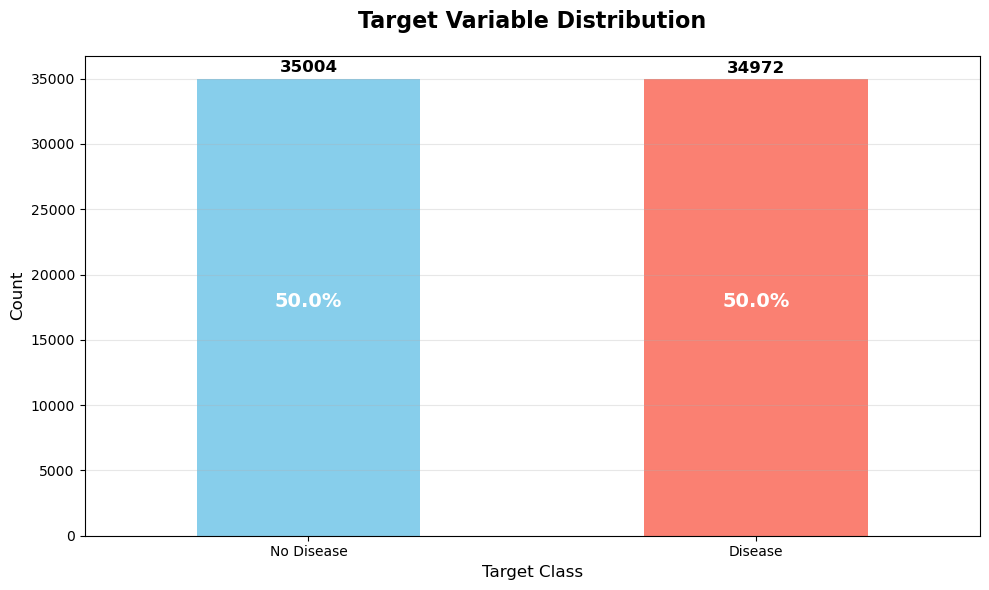

WindowsPath('p:/projects/heart_disease_prediction/reports/visualizations/univariate_analysis/numerical_analysis/01_target_distribution.png')

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def plot_target_distribution(df, save_path=None):
  
    # Set up paths
    if save_path is None:
        # Navigate to project root
        current_path = Path.cwd()
        while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
            current_path = current_path.parent
        
        # Define directories
        PROJECT_ROOT = current_path
        PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'numerical_analysis'
        
        # Create directory only if it doesn't exist
        PLOT_DIR.mkdir(parents=True, exist_ok=True)
        
        save_path = PLOT_DIR / '01_target_distribution.png'
    else:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Bar plot
    df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    
    # Add count labels on bars
    for i, v in enumerate(df['target'].value_counts()):
        plt.text(i, v + 500, str(v), ha='center', fontweight='bold', fontsize=12)
    
    # Formatting
    plt.title('Target Variable Distribution', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Target Class', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    total = len(df)
    for i, v in enumerate(df['target'].value_counts()):
        pct = (v / total * 100)
        plt.text(i, v/2, f'{pct:.1f}%', ha='center', fontweight='bold', 
                 fontsize=14, color='white')
    
    plt.tight_layout()
    
    # Save (always overwrites existing file)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: {save_path}")
    
    # Display
    plt.show()
    plt.close()
    
    return save_path

plot_target_distribution(df)

## Exploratory Data Analysis (Feature Engineering)

### Numerical Analysis

 ✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\02_age_analysis_univariate.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\2419923726.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='Age_Years', data=df_boxplot, ax=ax2,


✓ Bivariate plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\02_age_analysis_bivariate.png


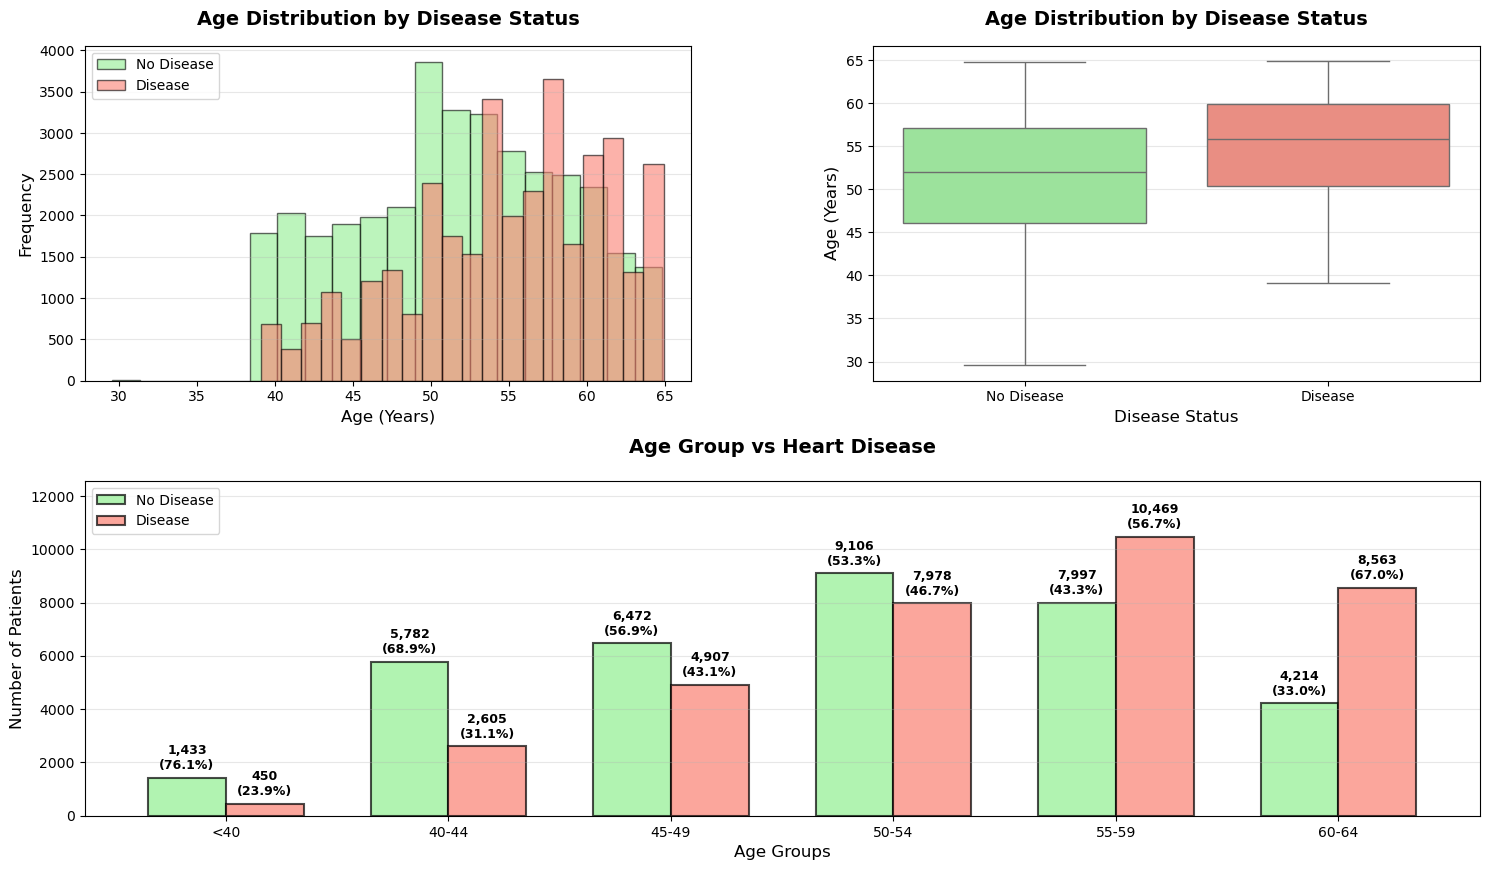

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==============================================================
# CREATE AGE GROUPS
# ==============================================================

age_bins = [0, 40, 45, 50, 55, 60, 65, 70, 120]
age_labels = ['<40', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70+']

df['Age_Group'] = pd.cut(df['Age_Years'], bins=age_bins, labels=age_labels, right=False)
df['Age_Group'] = pd.Categorical(df['Age_Group'], categories=age_labels, ordered=True)

# Get ONLY non-empty groups
age_group_counts = df['Age_Group'].value_counts().sort_index()
non_empty_groups = age_group_counts[age_group_counts > 0].index.tolist()

# ==============================================================
# SETUP PATHS
# ==============================================================

current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'numerical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'numerical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

# ==============================================================
# UNIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_univariate = plt.figure(figsize=(18, 10))
gs = fig_univariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_univariate.add_subplot(gs[0, 0])
ax2 = fig_univariate.add_subplot(gs[0, 1])
ax3 = fig_univariate.add_subplot(gs[1, :])

# Plot 1: Histogram
ax1.hist(df['Age_Years'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Age Distribution (Histogram)', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Age (Years)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Boxplot
ax2.boxplot(df['Age_Years'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_title('Age Distribution (Boxplot)', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Age (Years)', fontsize=12)
ax2.set_xticklabels([''])
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Age Group Bar Chart (ONLY non-empty bins)
overall_counts = age_group_counts[age_group_counts > 0]  # Filter out empty bins
total_patients = len(df)

bars = ax3.bar(range(len(overall_counts)), overall_counts.values,
               color='lightblue', alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_title('Age Group Distribution', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('Age Groups', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(range(len(overall_counts)))
ax3.set_xticklabels(overall_counts.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)

# Set y-axis limit
max_height = overall_counts.max()
ax3.set_ylim(0, max_height * 1.2)

# Add labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = height / total_patients * 100
    ax3.text(bar.get_x() + bar.get_width()/2, height + max_height*0.02,
             f'{int(height):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

univariate_path = UNIVARIATE_DIR / '02_age_analysis_univariate.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight')
print(f" ✓ Saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_bivariate = plt.figure(figsize=(18, 10))
gs = fig_bivariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_bivariate.add_subplot(gs[0, 0])
ax2 = fig_bivariate.add_subplot(gs[0, 1])
ax3 = fig_bivariate.add_subplot(gs[1, :])

# Determine target values
no_disease_val = 'No Disease' if 'No Disease' in df['target'].values else 0
disease_val = 'Disease' if 'Disease' in df['target'].values else 1

# Plot 1: Histogram by Target
for target_val, color, label in [(no_disease_val, 'lightgreen', 'No Disease'),
                                  (disease_val, 'salmon', 'Disease')]:
    data = df[df['target'] == target_val]['Age_Years']
    ax1.hist(data, bins=20, alpha=0.6, label=label, color=color, edgecolor='black')

ax1.set_title('Age Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Age (Years)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Boxplot by Target
df_boxplot = df[['Age_Years', 'target']].copy()
sns.boxplot(x='target', y='Age_Years', data=df_boxplot, ax=ax2,
            palette={no_disease_val: 'lightgreen', disease_val: 'salmon'})
ax2.set_title('Age Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Disease Status', fontsize=12)
ax2.set_ylabel('Age (Years)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Age Group Bar Chart by Target (ONLY non-empty bins)
target_pivot = (df.groupby(['Age_Group', 'target'])
                .size()
                .unstack(fill_value=0))

# Keep only non-empty age groups
target_pivot = target_pivot.loc[non_empty_groups]

bar_width = 0.35
x = np.arange(len(target_pivot))

# Determine column names
no_disease_col = no_disease_val
disease_col = disease_val

if no_disease_col in target_pivot.columns:
    ax3.bar(x - bar_width/2, target_pivot[no_disease_col],
            bar_width, label='No Disease', color='lightgreen',
            alpha=0.7, edgecolor='black', linewidth=1.5)

if disease_col in target_pivot.columns:
    ax3.bar(x + bar_width/2, target_pivot[disease_col],
            bar_width, label='Disease', color='salmon',
            alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.set_title('Age Group vs Heart Disease', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('Age Groups', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(target_pivot.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper left')

# Set y-axis limit
max_val = target_pivot.values.max()
ax3.set_ylim(0, max_val * 1.2)

# Add labels
for idx, age_grp in enumerate(target_pivot.index):
    grp_total = target_pivot.loc[age_grp].sum()
    if grp_total == 0:
        continue
    for offset, col in [(-bar_width/2, no_disease_col), (bar_width/2, disease_col)]:
        if col in target_pivot.columns:
            val = target_pivot.at[age_grp, col]
            if val > 0:
                ax3.text(idx + offset, val + max_val*0.02,
                        f'{int(val):,}\n({val/grp_total*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

bivariate_path = BIVARIATE_DIR / '02_age_analysis_bivariate.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Bivariate plot saved to: {bivariate_path}")
plt.show()
plt.close()

✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\03_bp_analysis_univariate.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\2504234533.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='Systolic_BP', data=df_boxplot, ax=ax2,


✓ Bivariate plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\03_bp_analysis_bivariate.png


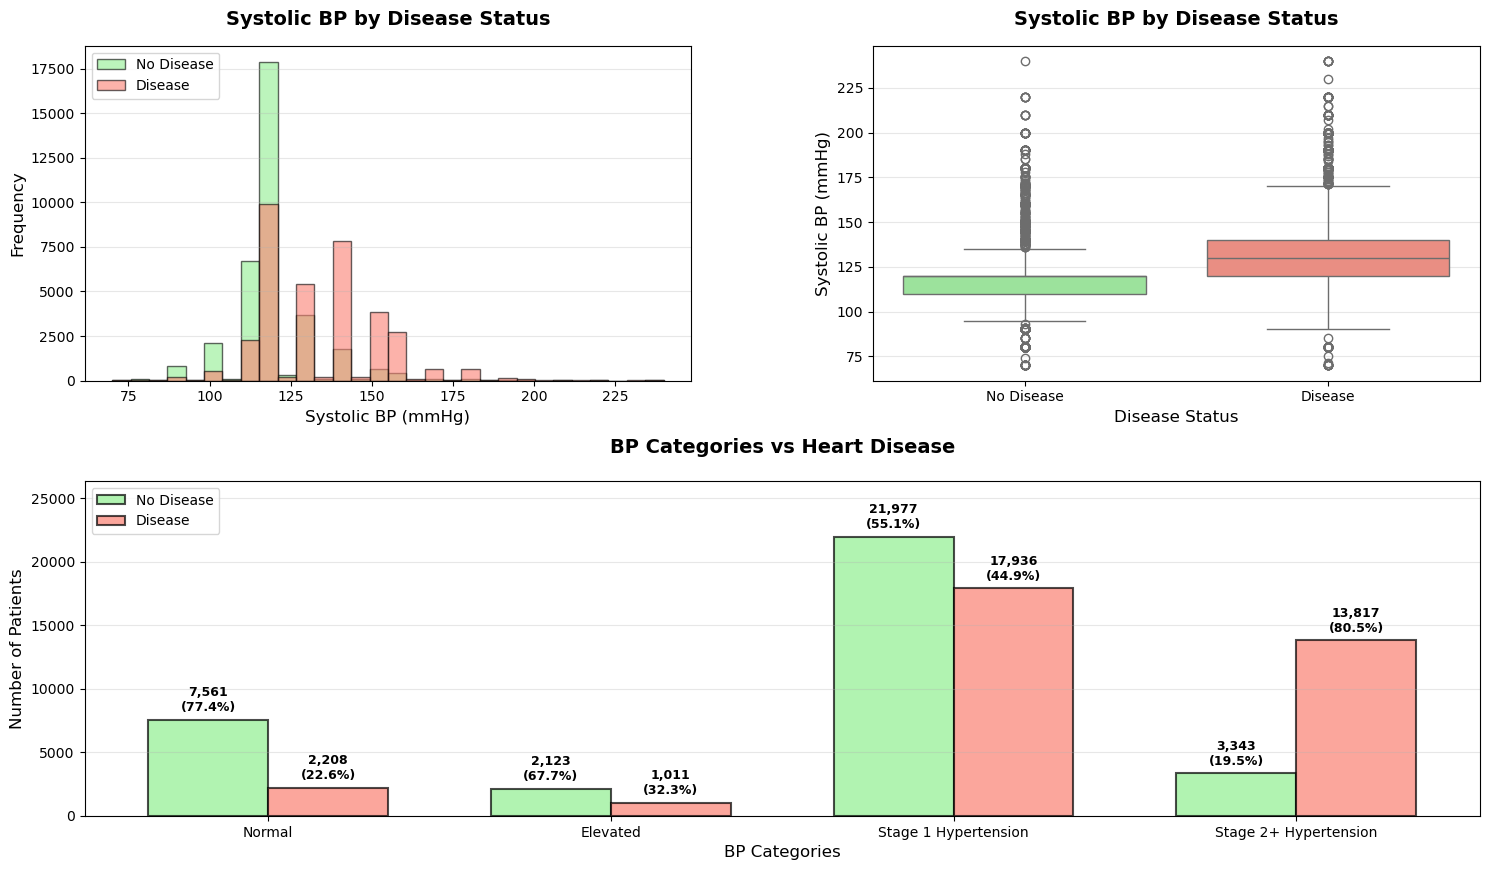

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==============================================================
# CREATE BP GROUPS WITH CLINICAL MERGING
# ==============================================================

def get_bp_category_merged(systolic, diastolic):
    """Categorize BP with clinical merging of rare categories"""
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif (130 <= systolic < 140) or (80 <= diastolic < 90):
        return 'Stage 1 Hypertension'
    else:
        return 'Stage 2+ Hypertension'

df['BP_Group'] = df.apply(lambda row: get_bp_category_merged(
    row['Systolic_BP'], row['Diastolic_BP']), axis=1)

bp_category_order = ['Normal', 'Elevated', 'Stage 1 Hypertension', 'Stage 2+ Hypertension']
df['BP_Group'] = pd.Categorical(df['BP_Group'], categories=bp_category_order, ordered=True)

# Get ONLY non-empty groups
bp_counts = df['BP_Group'].value_counts().sort_index()
non_empty_bp_groups = bp_counts[bp_counts > 0].index.tolist()

# ==============================================================
# SETUP PATHS
# ==============================================================

current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'numerical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'numerical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

colors = ['lightgreen', 'gold', 'orange', 'lightcoral']
color_dict = dict(zip(bp_category_order, colors))

# ==============================================================
# UNIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_univariate = plt.figure(figsize=(18, 10))
gs = fig_univariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_univariate.add_subplot(gs[0, 0])
ax2 = fig_univariate.add_subplot(gs[0, 1])
ax3 = fig_univariate.add_subplot(gs[1, :])

# Plot 1: Systolic BP Histogram
ax1.hist(df['Systolic_BP'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Systolic BP Distribution', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Systolic BP (mmHg)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Systolic BP Boxplot
ax2.boxplot(df['Systolic_BP'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_title('Systolic BP Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Systolic BP (mmHg)', fontsize=12)
ax2.set_xticklabels([''])
ax2.grid(axis='y', alpha=0.3)

# Plot 3: BP Group Bar Chart (bottom, full width, ONLY non-empty)
overall_counts = bp_counts[bp_counts > 0]
total_patients = len(df)

bars = ax3.bar(range(len(overall_counts)), overall_counts.values,
               color=[color_dict.get(g, 'gray') for g in overall_counts.index],
               alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_title('Blood Pressure Categories', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('BP Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(range(len(overall_counts)))
ax3.set_xticklabels(overall_counts.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)

max_height = overall_counts.max()
ax3.set_ylim(0, max_height * 1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = height / total_patients * 100
    ax3.text(bar.get_x() + bar.get_width()/2, height + max_height*0.02,
             f'{int(height):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

univariate_path = UNIVARIATE_DIR / '03_bp_analysis_univariate.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_bivariate = plt.figure(figsize=(18, 10))
gs = fig_bivariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_bivariate.add_subplot(gs[0, 0])
ax2 = fig_bivariate.add_subplot(gs[0, 1])
ax3 = fig_bivariate.add_subplot(gs[1, :])

no_disease_val = 'No Disease' if 'No Disease' in df['target'].values else 0
disease_val = 'Disease' if 'Disease' in df['target'].values else 1

# Plot 1: Systolic BP Histogram by Target
for target_val, color, label in [(no_disease_val, 'lightgreen', 'No Disease'),
                                  (disease_val, 'salmon', 'Disease')]:
    data = df[df['target'] == target_val]['Systolic_BP']
    ax1.hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

ax1.set_title('Systolic BP by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Systolic BP (mmHg)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Systolic BP Boxplot by Target
df_boxplot = df[['Systolic_BP', 'target']].copy()
sns.boxplot(x='target', y='Systolic_BP', data=df_boxplot, ax=ax2,
            palette={no_disease_val: 'lightgreen', disease_val: 'salmon'})
ax2.set_title('Systolic BP by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Disease Status', fontsize=12)
ax2.set_ylabel('Systolic BP (mmHg)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: BP Group Bar Chart by Target (bottom, full width, ONLY non-empty)
bp_target = (df.groupby(['BP_Group', 'target'])
             .size()
             .unstack(fill_value=0))
bp_target = bp_target.loc[non_empty_bp_groups]

bar_width = 0.35
x = np.arange(len(bp_target))

no_disease_col = no_disease_val
disease_col = disease_val

if no_disease_col in bp_target.columns:
    ax3.bar(x - bar_width/2, bp_target[no_disease_col],
            bar_width, label='No Disease', color='lightgreen',
            alpha=0.7, edgecolor='black', linewidth=1.5)

if disease_col in bp_target.columns:
    ax3.bar(x + bar_width/2, bp_target[disease_col],
            bar_width, label='Disease', color='salmon',
            alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.set_title('BP Categories vs Heart Disease', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('BP Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(bp_target.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper left')

max_val = bp_target.values.max()
ax3.set_ylim(0, max_val * 1.2)

for idx, bp_grp in enumerate(bp_target.index):
    grp_total = bp_target.loc[bp_grp].sum()
    if grp_total == 0:
        continue
    for offset, col in [(-bar_width/2, no_disease_col), (bar_width/2, disease_col)]:
        if col in bp_target.columns:
            val = bp_target.at[bp_grp, col]
            if val > 0:
                ax3.text(idx + offset, val + max_val*0.02,
                        f'{int(val):,}\n({val/grp_total*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

bivariate_path = BIVARIATE_DIR / '03_bp_analysis_bivariate.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Bivariate plot saved to: {bivariate_path}")
plt.show()
plt.close()

⚠️  Removing 5 invalid PP values
✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\04_pp_analysis_univariate.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\988452607.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='Pulse_Pressure', data=df_boxplot, ax=ax2,


✓ Bivariate plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\04_pp_analysis_bivariate.png


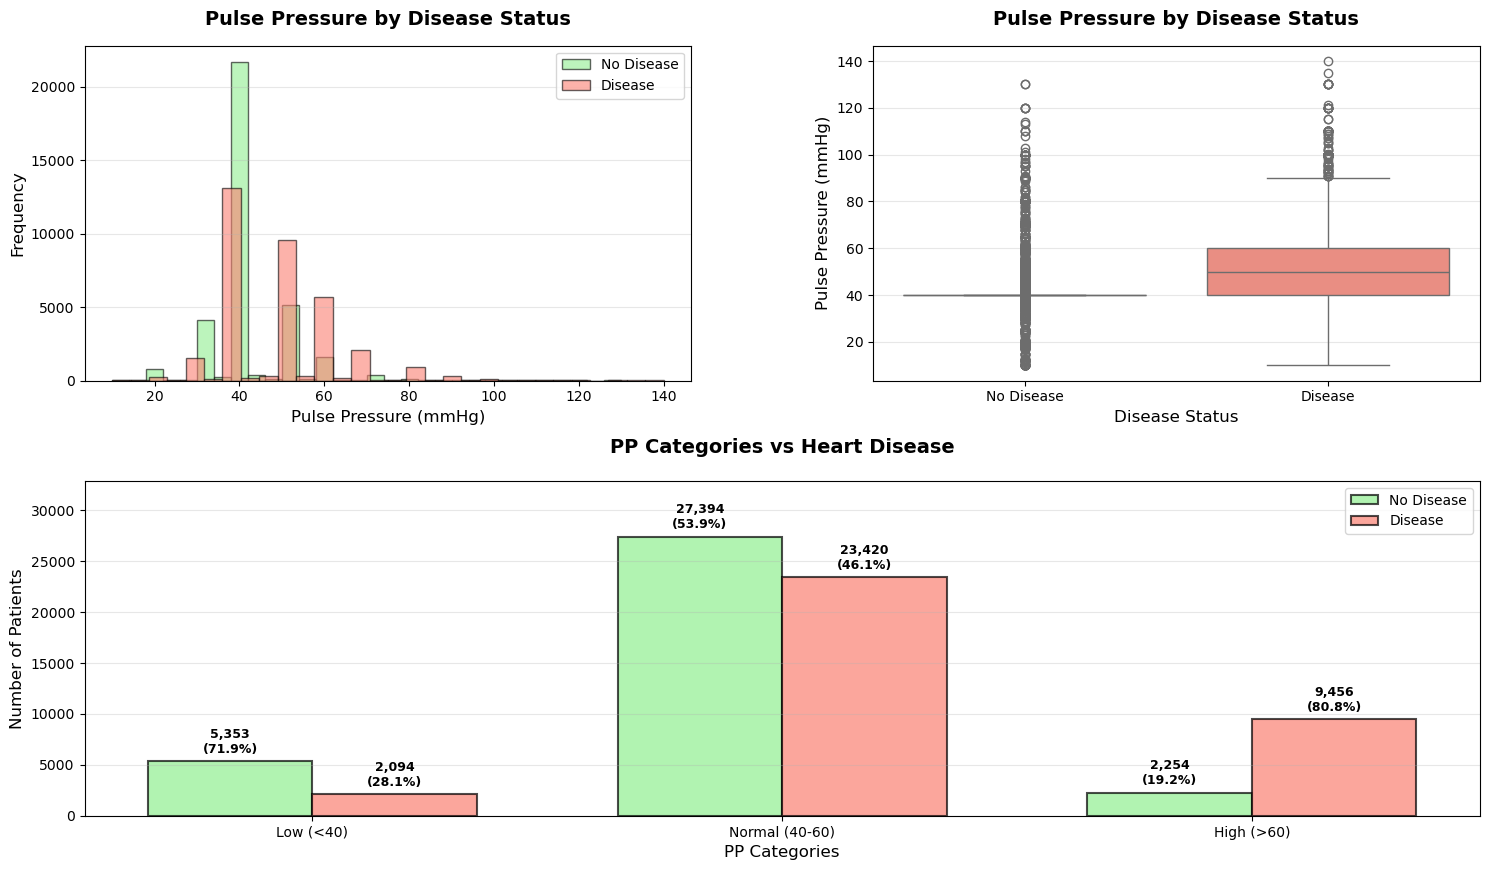

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==============================================================
# PULSE PRESSURE CALCULATION AND VALIDATION
# ==============================================================

if 'Pulse_Pressure' not in df.columns:
    df['Pulse_Pressure'] = df['Systolic_BP'] - df['Diastolic_BP']

# Remove invalid PP values
PP_MIN, PP_MAX = 10, 200
invalid_pp = (df['Pulse_Pressure'] < PP_MIN) | (df['Pulse_Pressure'] > PP_MAX)
invalid_count = invalid_pp.sum()

if invalid_count > 0:
    print(f"⚠️  Removing {invalid_count} invalid PP values")
    df = df[~invalid_pp].copy()

# Create PP Groups
pp_bins = [0, 40, 60, 200]
pp_labels = ['Low (<40)', 'Normal (40-60)', 'High (>60)']
df['PP_Group'] = pd.cut(df['Pulse_Pressure'], bins=pp_bins, labels=pp_labels, right=False)
df['PP_Group'] = pd.Categorical(df['PP_Group'], categories=pp_labels, ordered=True)

# Get ONLY non-empty groups
pp_counts = df['PP_Group'].value_counts().sort_index()
non_empty_pp_groups = pp_counts[pp_counts > 0].index.tolist()

# ==============================================================
# SETUP PATHS
# ==============================================================

current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'numerical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'numerical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

colors = ['#ADD8E6', 'lightgreen', 'salmon']
color_dict = dict(zip(pp_labels, colors))

# ==============================================================
# UNIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_univariate = plt.figure(figsize=(18, 10))
gs = fig_univariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_univariate.add_subplot(gs[0, 0])
ax2 = fig_univariate.add_subplot(gs[0, 1])
ax3 = fig_univariate.add_subplot(gs[1, :])

# Plot 1: PP Histogram
ax1.hist(df['Pulse_Pressure'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Pulse Pressure Distribution', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Pulse Pressure (mmHg)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: PP Boxplot
ax2.boxplot(df['Pulse_Pressure'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_title('Pulse Pressure Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Pulse Pressure (mmHg)', fontsize=12)
ax2.set_xticklabels([''])
ax2.grid(axis='y', alpha=0.3)

# Plot 3: PP Group Bar Chart (bottom, full width, ONLY non-empty)
overall_counts = pp_counts[pp_counts > 0]
total_patients = len(df)

bars = ax3.bar(range(len(overall_counts)), overall_counts.values,
               color=[color_dict.get(g, 'gray') for g in overall_counts.index],
               alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_title('Pulse Pressure Categories', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('PP Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(range(len(overall_counts)))
ax3.set_xticklabels(overall_counts.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)

max_height = overall_counts.max()
ax3.set_ylim(0, max_height * 1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = height / total_patients * 100
    ax3.text(bar.get_x() + bar.get_width()/2, height + max_height*0.02,
             f'{int(height):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

univariate_path = UNIVARIATE_DIR / '04_pp_analysis_univariate.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_bivariate = plt.figure(figsize=(18, 10))
gs = fig_bivariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_bivariate.add_subplot(gs[0, 0])
ax2 = fig_bivariate.add_subplot(gs[0, 1])
ax3 = fig_bivariate.add_subplot(gs[1, :])

no_disease_val = 'No Disease' if 'No Disease' in df['target'].values else 0
disease_val = 'Disease' if 'Disease' in df['target'].values else 1

# Plot 1: PP Histogram by Target
for target_val, color, label in [(no_disease_val, 'lightgreen', 'No Disease'),
                                  (disease_val, 'salmon', 'Disease')]:
    data = df[df['target'] == target_val]['Pulse_Pressure']
    ax1.hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

ax1.set_title('Pulse Pressure by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Pulse Pressure (mmHg)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: PP Boxplot by Target
df_boxplot = df[['Pulse_Pressure', 'target']].copy()
sns.boxplot(x='target', y='Pulse_Pressure', data=df_boxplot, ax=ax2,
            palette={no_disease_val: 'lightgreen', disease_val: 'salmon'})
ax2.set_title('Pulse Pressure by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Disease Status', fontsize=12)
ax2.set_ylabel('Pulse Pressure (mmHg)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: PP Group Bar Chart by Target (bottom, full width, ONLY non-empty)
pp_target = (df.groupby(['PP_Group', 'target'])
             .size()
             .unstack(fill_value=0))
pp_target = pp_target.loc[non_empty_pp_groups]

bar_width = 0.35
x = np.arange(len(pp_target))

no_disease_col = no_disease_val
disease_col = disease_val

if no_disease_col in pp_target.columns:
    ax3.bar(x - bar_width/2, pp_target[no_disease_col],
            bar_width, label='No Disease', color='lightgreen',
            alpha=0.7, edgecolor='black', linewidth=1.5)

if disease_col in pp_target.columns:
    ax3.bar(x + bar_width/2, pp_target[disease_col],
            bar_width, label='Disease', color='salmon',
            alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.set_title('PP Categories vs Heart Disease', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('PP Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(pp_target.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper right')

max_val = pp_target.values.max()
ax3.set_ylim(0, max_val * 1.2)

for idx, pp_grp in enumerate(pp_target.index):
    grp_total = pp_target.loc[pp_grp].sum()
    if grp_total == 0:
        continue
    for offset, col in [(-bar_width/2, no_disease_col), (bar_width/2, disease_col)]:
        if col in pp_target.columns:
            val = pp_target.at[pp_grp, col]
            if val > 0:
                ax3.text(idx + offset, val + max_val*0.02,
                        f'{int(val):,}\n({val/grp_total*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

bivariate_path = BIVARIATE_DIR / '04_pp_analysis_bivariate.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Bivariate plot saved to: {bivariate_path}")
plt.show()
plt.close()

✓ MAP created: 50.0 - 173.3 mmHg
✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\05_map_analysis_univariate.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\2860309366.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='MAP', data=df_boxplot, ax=ax2,


✓ Bivariate plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\05_map_analysis_bivariate.png


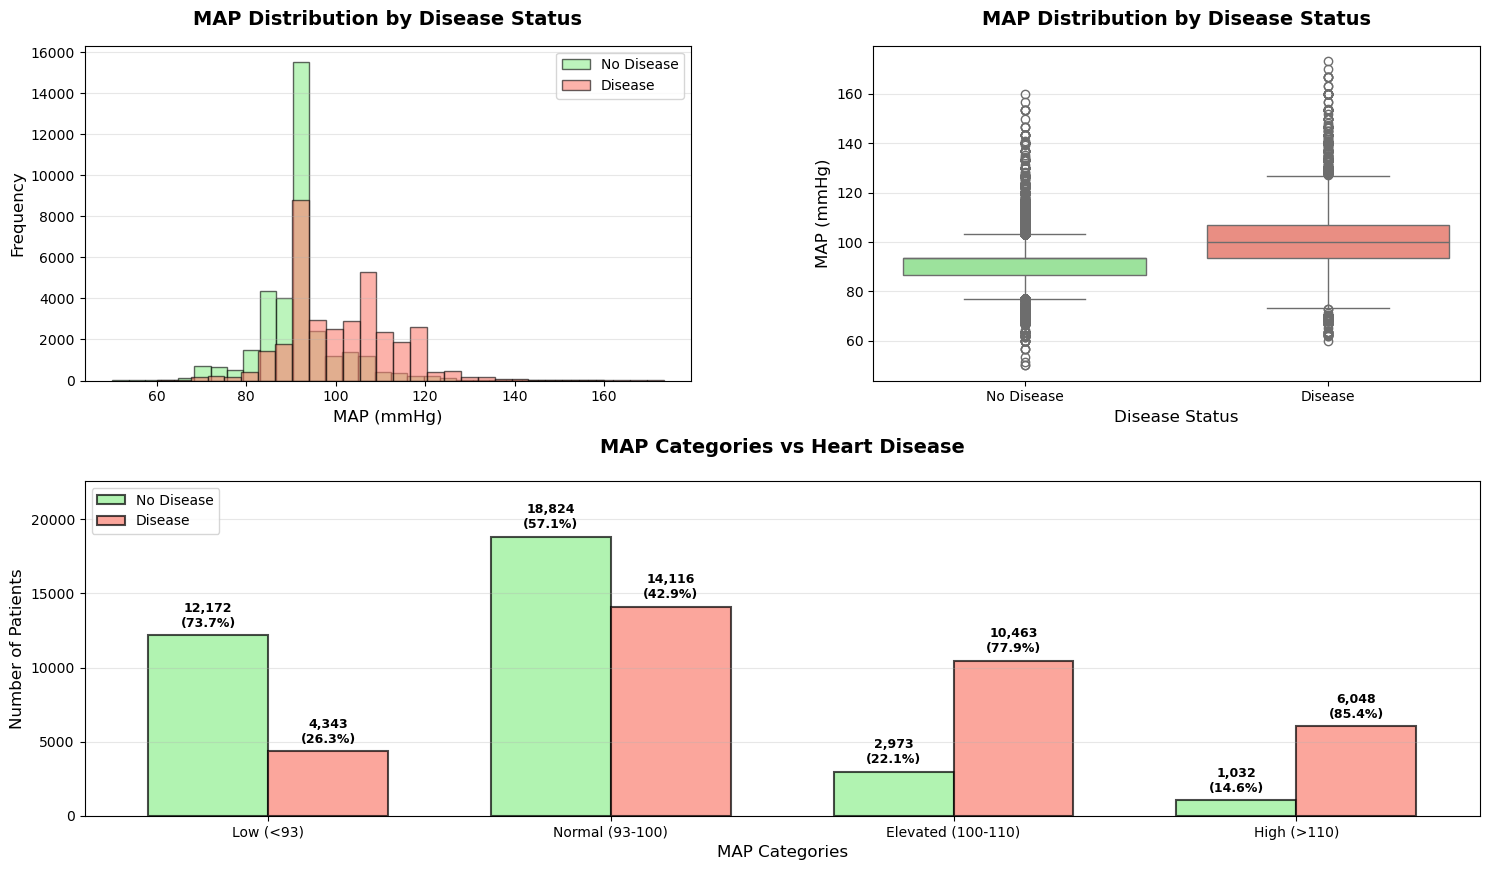

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==============================================================
# MAP (MEAN ARTERIAL PRESSURE) ANALYSIS
# ==============================================================
# Calculate MAP if not exists
if 'MAP' not in df.columns:
    df['MAP'] = df['Diastolic_BP'] + (df['Pulse_Pressure'] / 3)
    print(f"✓ MAP created: {df['MAP'].min():.1f} - {df['MAP'].max():.1f} mmHg")

# MAP Groups (4 categories based on clinical + data distribution)
df['MAP_Group'] = pd.cut(
    df['MAP'],
    bins=[0, 93, 100, 110, np.inf],
    labels=['Low (<93)', 'Normal (93-100)', 'Elevated (100-110)', 'High (>110)']
)

# Get ONLY non-empty groups
map_counts = df['MAP_Group'].value_counts().sort_index()
non_empty_groups = map_counts[map_counts > 0].index.tolist()

# ==============================================================
# SETUP PATHS
# ==============================================================

current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'numerical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'numerical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

# Color scheme
colors = ['lightblue', 'lightgreen', 'gold', 'salmon']
map_labels = ['Low (<93)', 'Normal (93-100)', 'Elevated (100-110)', 'High (>110)']
color_dict = dict(zip(map_labels, colors))

# ==============================================================
# UNIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_univariate = plt.figure(figsize=(18, 10))
gs = fig_univariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_univariate.add_subplot(gs[0, 0])
ax2 = fig_univariate.add_subplot(gs[0, 1])
ax3 = fig_univariate.add_subplot(gs[1, :])

# Plot 1: MAP Histogram
ax1.hist(df['MAP'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('MAP Distribution', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('MAP (mmHg)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: MAP Boxplot
ax2.boxplot(df['MAP'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_title('MAP Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('MAP (mmHg)', fontsize=12)
ax2.set_xticklabels([''])
ax2.grid(axis='y', alpha=0.3)

# Plot 3: MAP Group Bar Chart (bottom, full width, ONLY non-empty)
overall_counts = map_counts[map_counts > 0]
total_patients = len(df)

bars = ax3.bar(range(len(overall_counts)), overall_counts.values,
               color=[color_dict.get(g, 'gray') for g in overall_counts.index],
               alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_title('MAP Categories', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('MAP Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(range(len(overall_counts)))
ax3.set_xticklabels(overall_counts.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)

max_height = overall_counts.max()
ax3.set_ylim(0, max_height * 1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = height / total_patients * 100
    ax3.text(bar.get_x() + bar.get_width()/2, height + max_height*0.02,
             f'{int(height):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

univariate_path = UNIVARIATE_DIR / '05_map_analysis_univariate.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_bivariate = plt.figure(figsize=(18, 10))
gs = fig_bivariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_bivariate.add_subplot(gs[0, 0])
ax2 = fig_bivariate.add_subplot(gs[0, 1])
ax3 = fig_bivariate.add_subplot(gs[1, :])

no_disease_val = 'No Disease' if 'No Disease' in df['target'].values else 0
disease_val = 'Disease' if 'Disease' in df['target'].values else 1

# Plot 1: MAP Histogram by Target
for target_val, color, label in [(no_disease_val, 'lightgreen', 'No Disease'),
                                  (disease_val, 'salmon', 'Disease')]:
    data = df[df['target'] == target_val]['MAP']
    ax1.hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

ax1.set_title('MAP Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('MAP (mmHg)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: MAP Boxplot by Target
df_boxplot = df[['MAP', 'target']].copy()
sns.boxplot(x='target', y='MAP', data=df_boxplot, ax=ax2,
            palette={no_disease_val: 'lightgreen', disease_val: 'salmon'})
ax2.set_title('MAP Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Disease Status', fontsize=12)
ax2.set_ylabel('MAP (mmHg)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: MAP Group Bar Chart by Target (bottom, full width, ONLY non-empty)
map_target = (df.groupby(['MAP_Group', 'target'])
              .size()
              .unstack(fill_value=0))
map_target = map_target.loc[non_empty_groups]

bar_width = 0.35
x = np.arange(len(map_target))

no_disease_col = no_disease_val
disease_col = disease_val

if no_disease_col in map_target.columns:
    ax3.bar(x - bar_width/2, map_target[no_disease_col],
            bar_width, label='No Disease', color='lightgreen',
            alpha=0.7, edgecolor='black', linewidth=1.5)

if disease_col in map_target.columns:
    ax3.bar(x + bar_width/2, map_target[disease_col],
            bar_width, label='Disease', color='salmon',
            alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.set_title('MAP Categories vs Heart Disease', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('MAP Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(map_target.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper left')

max_val = map_target.values.max()
ax3.set_ylim(0, max_val * 1.2)

for idx, map_grp in enumerate(map_target.index):
    grp_total = map_target.loc[map_grp].sum()
    if grp_total == 0:
        continue
    for offset, col in [(-bar_width/2, no_disease_col), (bar_width/2, disease_col)]:
        if col in map_target.columns:
            val = map_target.at[map_grp, col]
            if val > 0:
                ax3.text(idx + offset, val + max_val*0.02,
                        f'{int(val):,}\n({val/grp_total*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

bivariate_path = BIVARIATE_DIR / '05_map_analysis_bivariate.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Bivariate plot saved to: {bivariate_path}")
plt.show()
plt.close()

✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\06_bmi_analysis_univariate.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\3409569967.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='BMI', data=df_boxplot, ax=ax2,


✓ Bivariate plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\06_bmi_analysis_bivariate.png


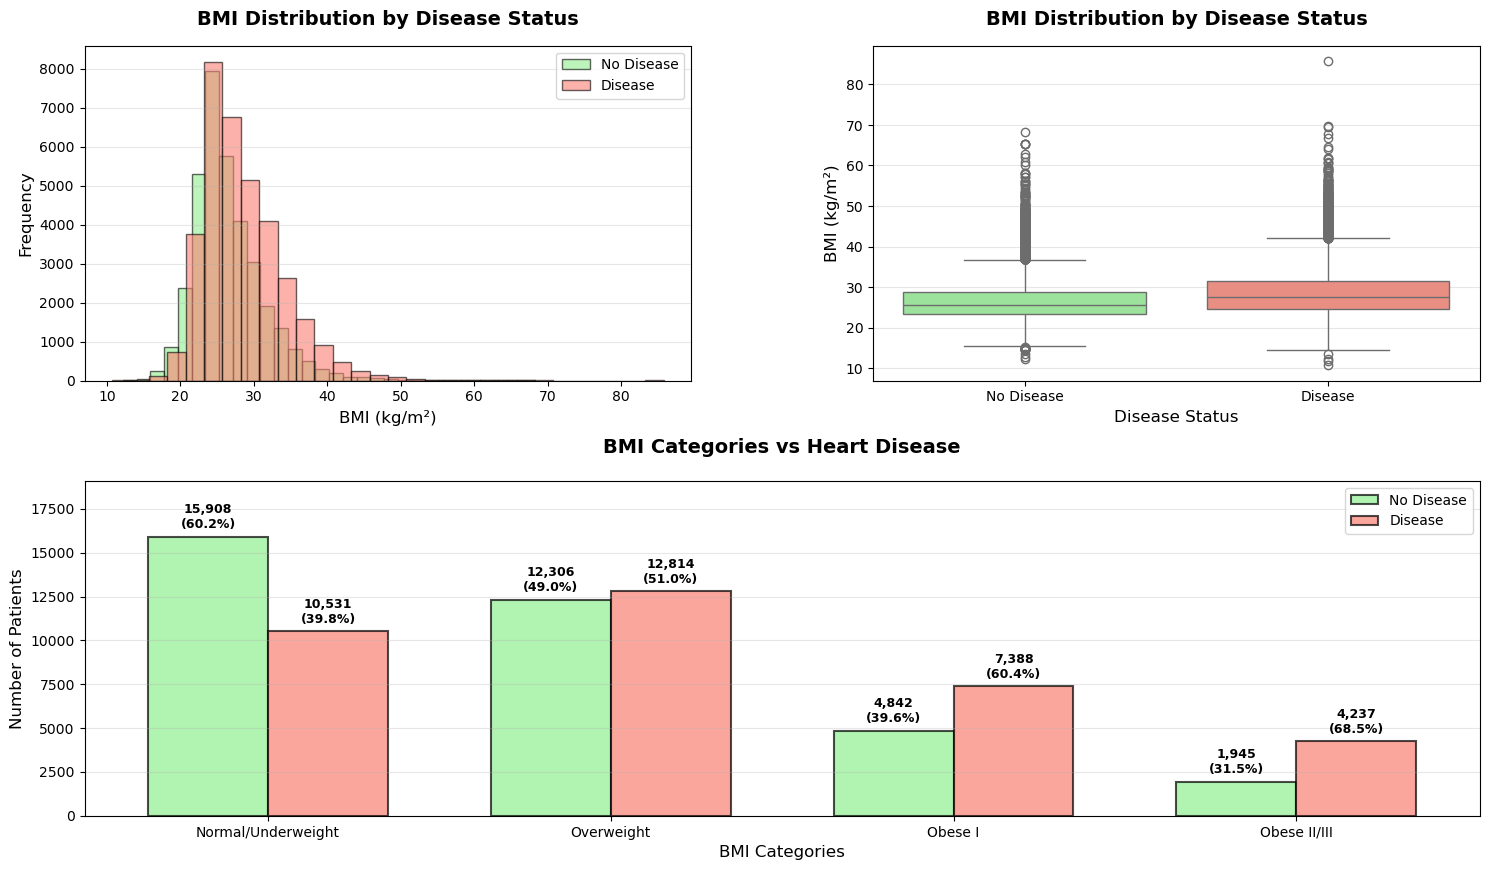

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==============================================================
# BMI CALCULATION AND CATEGORIZATION
# ==============================================================
# Calculate BMI (kg/m²)
if 'BMI' not in df.columns:
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

# Handle NaN values
bmi_nan = df['BMI'].isna().sum()
if bmi_nan > 0:
    bmi_median = df['BMI'].median()
    df['BMI'].fillna(bmi_median, inplace=True)
    print(f"✓ Imputed {bmi_nan} NaN BMI values with median {bmi_median:.2f}")

# Define BMI categories
bmi_bins = [0, 25, 30, 35, 100]
bmi_labels = ['Normal/Underweight', 'Overweight', 'Obese I', 'Obese II/III']

df['BMI_Group'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)
df['BMI_Group'] = pd.Categorical(df['BMI_Group'], categories=bmi_labels, ordered=True)

# Get ONLY non-empty groups
bmi_counts = df['BMI_Group'].value_counts().sort_index()
non_empty_groups = bmi_counts[bmi_counts > 0].index.tolist()

# Drop Weight and Height
if 'Weight' in df.columns and 'Height' in df.columns:
    df = df.drop(columns=['Weight', 'Height'])

# ==============================================================
# SETUP PATHS
# ==============================================================

current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'numerical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'numerical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

colors = ['lightgreen', 'gold', 'orange', 'lightcoral']
color_dict = dict(zip(bmi_labels, colors))

# ==============================================================
# UNIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_univariate = plt.figure(figsize=(18, 10))
gs = fig_univariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_univariate.add_subplot(gs[0, 0])
ax2 = fig_univariate.add_subplot(gs[0, 1])
ax3 = fig_univariate.add_subplot(gs[1, :])

# Plot 1: BMI Histogram
ax1.hist(df['BMI'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('BMI Distribution', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('BMI (kg/m²)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: BMI Boxplot
ax2.boxplot(df['BMI'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_title('BMI Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('BMI (kg/m²)', fontsize=12)
ax2.set_xticklabels([''])
ax2.grid(axis='y', alpha=0.3)

# Plot 3: BMI Group Bar Chart (bottom, full width, ONLY non-empty)
overall_counts = bmi_counts[bmi_counts > 0]
total_patients = len(df)

bars = ax3.bar(range(len(overall_counts)), overall_counts.values,
               color=[color_dict.get(g, 'gray') for g in overall_counts.index],
               alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_title('BMI Categories', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('BMI Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(range(len(overall_counts)))
ax3.set_xticklabels(overall_counts.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)

max_height = overall_counts.max()
ax3.set_ylim(0, max_height * 1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = height / total_patients * 100
    ax3.text(bar.get_x() + bar.get_width()/2, height + max_height*0.02,
             f'{int(height):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

univariate_path = UNIVARIATE_DIR / '06_bmi_analysis_univariate.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_bivariate = plt.figure(figsize=(18, 10))
gs = fig_bivariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_bivariate.add_subplot(gs[0, 0])
ax2 = fig_bivariate.add_subplot(gs[0, 1])
ax3 = fig_bivariate.add_subplot(gs[1, :])

no_disease_val = 'No Disease' if 'No Disease' in df['target'].values else 0
disease_val = 'Disease' if 'Disease' in df['target'].values else 1

# Plot 1: BMI Histogram by Target
for target_val, color, label in [(no_disease_val, 'lightgreen', 'No Disease'),
                                  (disease_val, 'salmon', 'Disease')]:
    data = df[df['target'] == target_val]['BMI']
    ax1.hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

ax1.set_title('BMI Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('BMI (kg/m²)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: BMI Boxplot by Target
df_boxplot = df[['BMI', 'target']].copy()
sns.boxplot(x='target', y='BMI', data=df_boxplot, ax=ax2,
            palette={no_disease_val: 'lightgreen', disease_val: 'salmon'})
ax2.set_title('BMI Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Disease Status', fontsize=12)
ax2.set_ylabel('BMI (kg/m²)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: BMI Group Bar Chart by Target (bottom, full width, ONLY non-empty)
bmi_target = (df.groupby(['BMI_Group', 'target'])
              .size()
              .unstack(fill_value=0))
bmi_target = bmi_target.loc[non_empty_groups]

bar_width = 0.35
x = np.arange(len(bmi_target))

no_disease_col = no_disease_val
disease_col = disease_val

if no_disease_col in bmi_target.columns:
    ax3.bar(x - bar_width/2, bmi_target[no_disease_col],
            bar_width, label='No Disease', color='lightgreen',
            alpha=0.7, edgecolor='black', linewidth=1.5)

if disease_col in bmi_target.columns:
    ax3.bar(x + bar_width/2, bmi_target[disease_col],
            bar_width, label='Disease', color='salmon',
            alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.set_title('BMI Categories vs Heart Disease', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('BMI Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(bmi_target.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper right')

max_val = bmi_target.values.max()
ax3.set_ylim(0, max_val * 1.2)

for idx, bmi_grp in enumerate(bmi_target.index):
    grp_total = bmi_target.loc[bmi_grp].sum()
    if grp_total == 0:
        continue
    for offset, col in [(-bar_width/2, no_disease_col), (bar_width/2, disease_col)]:
        if col in bmi_target.columns:
            val = bmi_target.at[bmi_grp, col]
            if val > 0:
                ax3.text(idx + offset, val + max_val*0.02,
                        f'{int(val):,}\n({val/grp_total*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

bivariate_path = BIVARIATE_DIR / '06_bmi_analysis_bivariate.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Bivariate plot saved to: {bivariate_path}")
plt.show()
plt.close()


✓ Raw features: ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP']
✓ Engineered features: ['Pulse_Pressure', 'MAP']
✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\07_pairplot_raw_features_univariate.png

BIVARIATE PAIRPLOT: RAW FEATURES (With target)
✓ Saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\07_pairplot_raw_features_bivariate.png


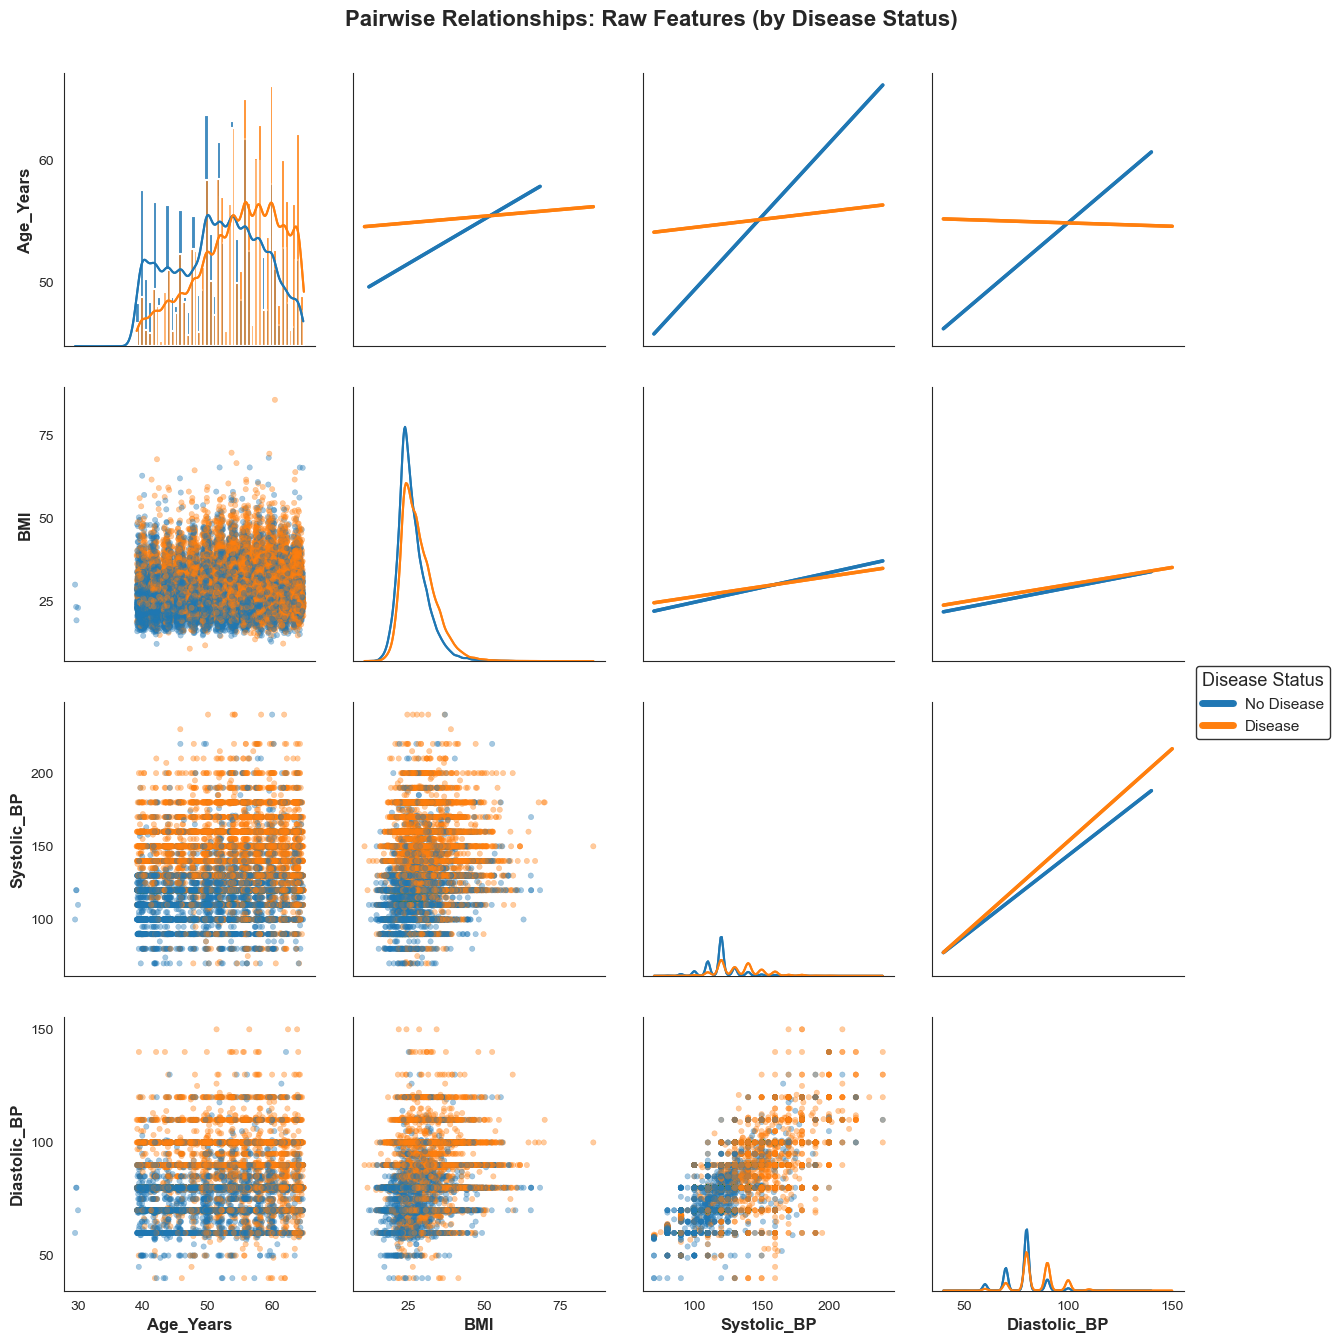

✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\08_pairplot_engineered_features_univariate.png
✓ Saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\08_pairplot_engineered_features_bivariate.png


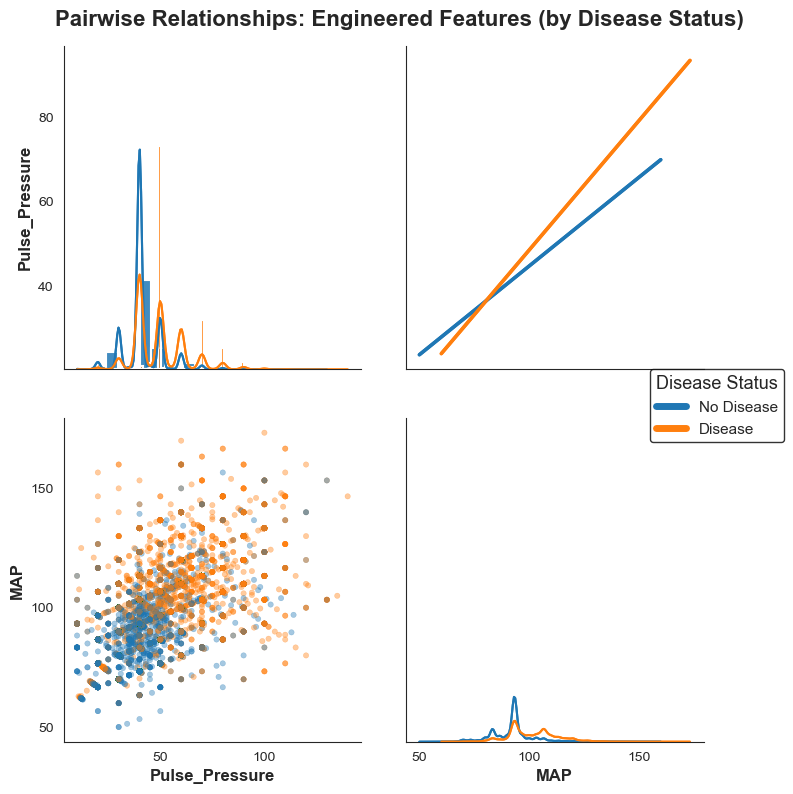

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==============================================================
# PAIRWISE RELATIONSHIP ANALYSIS (PAIRPLOT)
# ==============================================================
# Setup directories

current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'numerical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'numerical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

# ==============================================================
# Define feature groups
# ==============================================================

raw_features = ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP']
engineered_features = ['Pulse_Pressure', 'MAP']

print(f"\n✓ Raw features: {raw_features}")
print(f"✓ Engineered features: {engineered_features}")

# ==============================================================
# Target palette
# ==============================================================

TARGET_PALETTE_LIST = ['#1f77b4', '#ff7f0e']
PAIRGRID_PALETTE = dict(zip(['No Disease', 'Disease'], TARGET_PALETTE_LIST))

# ==============================================================
# Prepare DataFrame
# ==============================================================

df_plot = df.copy()
if 'target_name' not in df_plot.columns:
    if df_plot['target'].dtype == 'object':
        df_plot['target_name'] = df_plot['target']
    else:
        df_plot['target_name'] = df_plot['target'].map({0: 'No Disease', 1: 'Disease'})

# Styling
sns.set_style("white")

# ==============================================================
# UNIVARIATE PAIRPLOT: RAW FEATURES (SAVE BUT DON'T DISPLAY)
# ==============================================================

g1_uni = sns.PairGrid(
    df_plot,
    vars=raw_features,
    diag_sharey=False,
    height=3.5,
    aspect=1.0
)

# Upper: only regplot (no scatter)
g1_uni.map_upper(sns.regplot, scatter=False, color='gray', line_kws={'linewidth': 2})

# Lower: scatter without color
g1_uni.map_lower(sns.scatterplot, alpha=0.3, s=15, edgecolor=None, color='gray')

# Diagonal: histogram
g1_uni.map_diag(sns.histplot, color='steelblue', alpha=0.6, kde=True)

# Remove grid
for ax_row in g1_uni.axes:
    for ax in ax_row:
        ax.grid(False)
        ax.locator_params(axis='both', nbins=4)

# Set labels
for i, var in enumerate(raw_features):
    g1_uni.axes[i, 0].set_ylabel(var, fontsize=12, fontweight='bold')
    g1_uni.axes[-1, i].set_xlabel(var, fontsize=12, fontweight='bold')

g1_uni.fig.suptitle('Pairwise Relationships: Raw Features', fontsize=16, y=0.995, weight='bold')

plt.subplots_adjust(hspace=0.15, wspace=0.15, top=0.95, bottom=0.08)

# Save (no display)
univariate_raw_path = UNIVARIATE_DIR / '07_pairplot_raw_features_univariate.png'
plt.savefig(univariate_raw_path, bbox_inches='tight', dpi=200, facecolor='white')
print(f"✓ Saved (hidden): {univariate_raw_path}")
plt.close()  # Close without showing

# ==============================================================
# BIVARIATE PAIRPLOT: RAW FEATURES (SAVE AND DISPLAY)
# ==============================================================

print("\n" + "="*70)
print("BIVARIATE PAIRPLOT: RAW FEATURES (With target)")
print("="*70)

g1_bi = sns.PairGrid(
    df_plot,
    vars=raw_features,
    hue='target_name',
    palette=PAIRGRID_PALETTE,
    diag_sharey=False,
    height=3.5,
    aspect=1.0
)

# Upper: ONLY regplot by target (no scatter, straight linear line)
def regplot_only(x, y, **kwargs):
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        if subset[x.name].notna().sum() > 2 and subset[y.name].notna().sum() > 2:
            sns.regplot(
                x=subset[x.name], y=subset[y.name], 
                scatter=False,  # No scatter points
                ci=None,        # No confidence interval
                order=1,        # Linear only (no polynomial smoothing)
                line_kws={'color': color, 'linewidth': 2.5},
                ax=plt.gca()
            )

g1_bi.map_upper(regplot_only)

# Lower: scatter by target
g1_bi.map_lower(sns.scatterplot, alpha=0.4, s=15, edgecolor=None)

# Diagonal: histogram by target
def hist_diag(x, **kwargs):
    ax = plt.gca()
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        if subset[x.name].notna().sum() > 1:
            sns.histplot(subset[x.name], color=color, alpha=0.6, kde=True, 
                        ax=ax, stat='density', linewidth=1.5)
    if ax.get_legend():
        ax.get_legend().remove()

g1_bi.map_diag(hist_diag)

# Remove grid
for ax_row in g1_bi.axes:
    for ax in ax_row:
        ax.grid(False)
        ax.locator_params(axis='both', nbins=4)

# Set labels
for i, var in enumerate(raw_features):
    g1_bi.axes[i, 0].set_ylabel(var, fontsize=12, fontweight='bold')
    g1_bi.axes[-1, i].set_xlabel(var, fontsize=12, fontweight='bold')

g1_bi.fig.suptitle('Pairwise Relationships: Raw Features (by Disease Status)', 
                   fontsize=16, y=0.995, weight='bold')

# Legend
handles = [plt.Line2D([0], [0], color=color, lw=5, label=name) 
           for name, color in PAIRGRID_PALETTE.items()]
g1_bi.fig.legend(
    handles, list(PAIRGRID_PALETTE.keys()), 
    title='Disease Status', 
    title_fontsize=13, fontsize=11,
    loc='center right',
    bbox_to_anchor=(0.99, 0.5),
    frameon=True, edgecolor='black'
)

plt.subplots_adjust(hspace=0.15, wspace=0.15, top=0.95, bottom=0.08, left=0.08, right=0.88)

# Save and display
bivariate_raw_path = BIVARIATE_DIR / '07_pairplot_raw_features_bivariate.png'
plt.savefig(bivariate_raw_path, bbox_inches='tight', dpi=200, facecolor='white')
print(f"✓ Saved: {bivariate_raw_path}")
plt.show()
plt.close()

# ==============================================================
# UNIVARIATE PAIRPLOT: ENGINEERED FEATURES (SAVE BUT DON'T DISPLAY)
# ==============================================================
g2_uni = sns.PairGrid(
    df_plot,
    vars=engineered_features,
    diag_sharey=False,
    height=4.0,
    aspect=1.0
)

g2_uni.map_upper(sns.regplot, scatter=False, color='gray', line_kws={'linewidth': 2})
g2_uni.map_lower(sns.scatterplot, alpha=0.3, s=15, edgecolor=None, color='gray')
g2_uni.map_diag(sns.histplot, color='steelblue', alpha=0.6, kde=True)

for ax_row in g2_uni.axes:
    for ax in ax_row:
        ax.grid(False)
        ax.locator_params(axis='both', nbins=4)

for i, var in enumerate(engineered_features):
    g2_uni.axes[i, 0].set_ylabel(var, fontsize=12, fontweight='bold')
    g2_uni.axes[-1, i].set_xlabel(var, fontsize=12, fontweight='bold')

g2_uni.fig.suptitle('Pairwise Relationships: Engineered Features', fontsize=16, y=0.995, weight='bold')
plt.subplots_adjust(hspace=0.15, wspace=0.15, top=0.95, bottom=0.08)

# Save (no display)
univariate_eng_path = UNIVARIATE_DIR / '08_pairplot_engineered_features_univariate.png'
plt.savefig(univariate_eng_path, bbox_inches='tight', dpi=200, facecolor='white')
print(f"✓ Saved (hidden): {univariate_eng_path}")
plt.close()

# ==============================================================
# BIVARIATE PAIRPLOT: ENGINEERED FEATURES (SAVE AND DISPLAY)
# ==============================================================
g2_bi = sns.PairGrid(
    df_plot,
    vars=engineered_features,
    hue='target_name',
    palette=PAIRGRID_PALETTE,
    diag_sharey=False,
    height=4.0,
    aspect=1.0
)

g2_bi.map_upper(regplot_only)  # Same linear-only regplot
g2_bi.map_lower(sns.scatterplot, alpha=0.4, s=15, edgecolor=None)
g2_bi.map_diag(hist_diag)

for ax_row in g2_bi.axes:
    for ax in ax_row:
        ax.grid(False)
        ax.locator_params(axis='both', nbins=4)

for i, var in enumerate(engineered_features):
    g2_bi.axes[i, 0].set_ylabel(var, fontsize=12, fontweight='bold')
    g2_bi.axes[-1, i].set_xlabel(var, fontsize=12, fontweight='bold')

g2_bi.fig.suptitle('Pairwise Relationships: Engineered Features (by Disease Status)', 
                   fontsize=16, y=0.995, weight='bold')

g2_bi.fig.legend(
    handles, list(PAIRGRID_PALETTE.keys()), 
    title='Disease Status', 
    title_fontsize=13, fontsize=11,
    loc='center right',
    bbox_to_anchor=(0.99, 0.5),
    frameon=True, edgecolor='black'
)

plt.subplots_adjust(hspace=0.15, wspace=0.15, top=0.95, bottom=0.08, left=0.08, right=0.88)

# Save and display
bivariate_eng_path = BIVARIATE_DIR / '08_pairplot_engineered_features_bivariate.png'
plt.savefig(bivariate_eng_path, bbox_inches='tight', dpi=200, facecolor='white')
print(f"✓ Saved: {bivariate_eng_path}")
plt.show()
plt.close()

# Cleanup
del df_plot


✓ Full correlation heatmap saved to: p:\projects\heart_disease_prediction\reports\visualizations\multivariate_analysis\09_correlation_heatmap.png


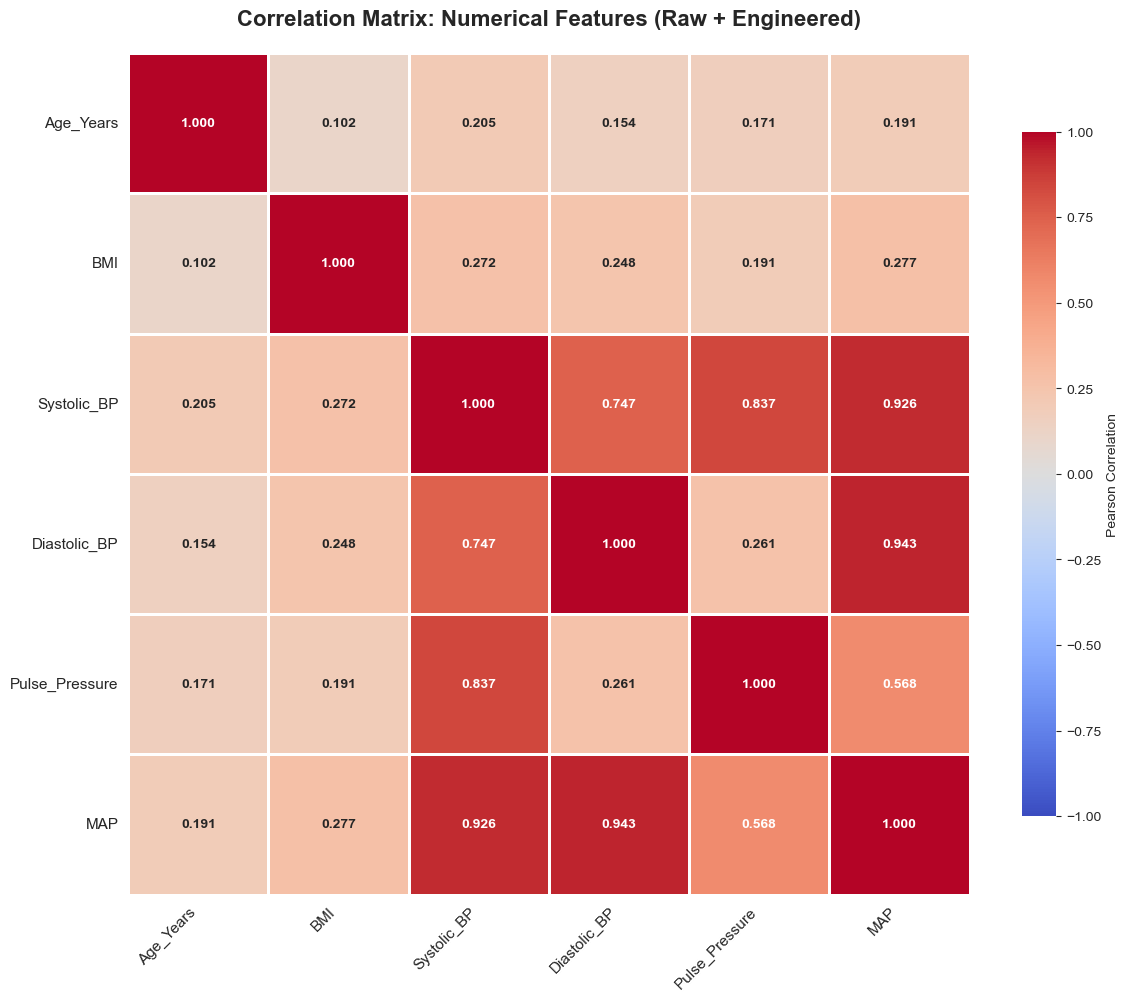


⚠️  High correlations found (|r| ≥ 0.8):
  Diastolic_BP ↔ MAP: 0.943
  Systolic_BP ↔ MAP: 0.926
  Systolic_BP ↔ Pulse_Pressure: 0.837

Average absolute correlation with other features:
  Systolic_BP: 0.664
  MAP: 0.651
  Diastolic_BP: 0.559
  Pulse_Pressure: 0.505
  BMI: 0.348
  Age_Years: 0.304

Top 5 Strongest Correlations:
  1. Diastolic_BP ↔ MAP: 0.943
  2. Systolic_BP ↔ MAP: 0.926
  3. Systolic_BP ↔ Pulse_Pressure: 0.837
  4. Systolic_BP ↔ Diastolic_BP: 0.747
  5. Pulse_Pressure ↔ MAP: 0.568


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

def create_numerical_correlation_heatmap(df, save_path=None):
    
    # Numerical features to analyze
    numerical_cols = ['Age_Years','BMI','Systolic_BP','Diastolic_BP','Pulse_Pressure','MAP']

    # Set default save path
    if save_path is None:
        # Navigate to project root
        current_path = Path.cwd()
        while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
            current_path = current_path.parent
        
        # Save to multivariate_analysis folder
        save_path = current_path / 'reports' / 'visualizations' / 'multivariate_analysis' / '09_correlation_heatmap.png'
    else:
        save_path = Path(save_path)
    
    # Create directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Calculate correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Create FULL heatmap (no mask)
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.3f',
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"},
        annot_kws={"fontsize": 10, "fontweight": "bold"}
    )
    
    plt.title('Correlation Matrix: Numerical Features (Raw + Engineered)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Full correlation heatmap saved to: {save_path}")
    
    # Display
    plt.show()
    plt.close()
    
    # Find high correlations (excluding diagonal)
    high_corr_threshold = 0.8
    high_corrs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) >= high_corr_threshold:
                high_corrs.append({
                    'Feature 1': corr_matrix.columns[i],
                    'Feature 2': corr_matrix.columns[j],
                    'Correlation': corr_val
                })
    
    if high_corrs:
        print(f"\n⚠️  High correlations found (|r| ≥ {high_corr_threshold}):")
        for hc in sorted(high_corrs, key=lambda x: abs(x['Correlation']), reverse=True):
            print(f"  {hc['Feature 1']} ↔ {hc['Feature 2']}: {hc['Correlation']:.3f}")
    else:
        print(f"\n✓ No extremely high correlations (|r| ≥ {high_corr_threshold})")
    
    # Average correlation with each feature
    print("\nAverage absolute correlation with other features:")
    avg_corrs = corr_matrix.abs().mean().sort_values(ascending=False)
    for feat, avg_corr in avg_corrs.items():
        print(f"  {feat}: {avg_corr:.3f}")
    
    # Strongest correlations (top 5)
    print("\nTop 5 Strongest Correlations:")
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    correlations = upper_tri.stack().sort_values(ascending=False, key=abs)
    for idx, (pair, corr) in enumerate(correlations.head(5).items(), 1):
        print(f"  {idx}. {pair[0]} ↔ {pair[1]}: {corr:.3f}")
    
    return corr_matrix

corr_matrix = create_numerical_correlation_heatmap(df)



✓ Analyzing 6 numerical features
✓ Sample size: 69,971 records
  Age_Years            VIF = 44.61
  BMI                  VIF = 29.15
  Systolic_BP          VIF = ∞ (Perfect multicollinearity)
  Diastolic_BP         VIF = ∞ (Perfect multicollinearity)
  Pulse_Pressure       VIF = ∞ (Perfect multicollinearity)
  MAP                  VIF = ∞ (Perfect multicollinearity)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\525321885.py:105: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\525321885.py:105: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\525321885.py:109: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.savefig(img_path, dpi=300, bbox_inches='tight', facecolor='white')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16980\525321885.py:109: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  plt.savefig(img_path, dpi=300, bbox_inches='tight', facecolor='white')



✓ Saved: p:\projects\heart_disease_prediction\reports\visualizations\multivariate_analysis\10_vif_analysis.png


p:\projects\heart_disease_prediction\heart_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
p:\projects\heart_disease_prediction\heart_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


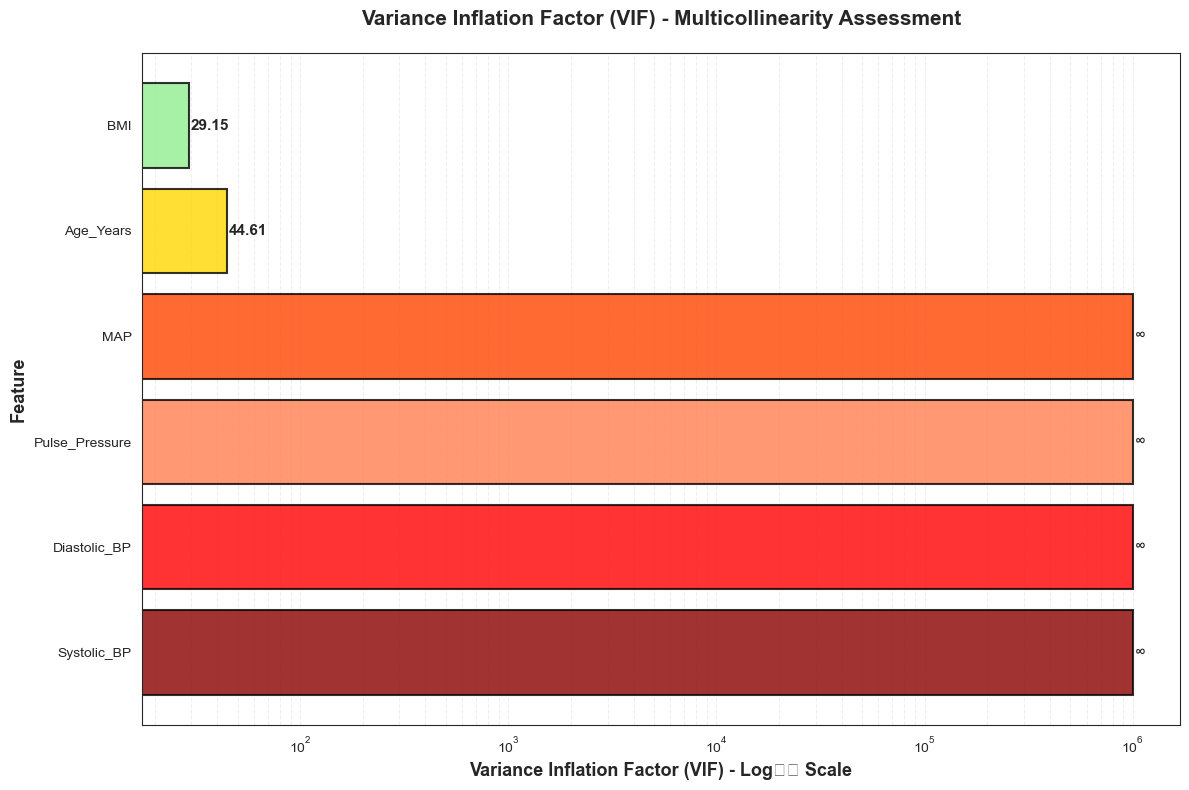

       Feature VIF_Display  Severity
   Systolic_BP           ∞ 🔴 Perfect
  Diastolic_BP           ∞ 🔴 Perfect
Pulse_Pressure           ∞ 🔴 Perfect
           MAP           ∞ 🔴 Perfect
     Age_Years       44.61    🔴 High
           BMI       29.15    🔴 High


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# ==============================================================
# VIF ANALYSIS - SIMPLE VERSION (10^x SCALE)
# ==============================================================

# Features to analyze
num_features = ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP', 
                'Pulse_Pressure', 'MAP']

# Setup directory
current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate_analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# Prepare data
df_vif = df[num_features].copy().dropna()

print(f"\n✓ Analyzing {len(num_features)} numerical features")
print(f"✓ Sample size: {len(df_vif):,} records")

# ==============================================================
# CALCULATE VIF
# ==============================================================
vif_results = []

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    for i, feature in enumerate(num_features):
        try:
            vif = variance_inflation_factor(df_vif.values, i)
            
            if np.isinf(vif) or np.isnan(vif):
                vif_results.append({'Feature': feature, 'VIF': float('inf')})
                print(f"  {feature:<20} VIF = ∞ (Perfect multicollinearity)")
            else:
                vif_results.append({'Feature': feature, 'VIF': vif})
                print(f"  {feature:<20} VIF = {vif:.2f}")
        except:
            vif_results.append({'Feature': feature, 'VIF': float('inf')})
            print(f"  {feature:<20} VIF = Error")

vif_data = pd.DataFrame(vif_results)

# Sort by VIF (handle infinity)
vif_data['Sort_Key'] = vif_data['VIF'].apply(lambda x: 1e10 if np.isinf(x) else x)
vif_data = vif_data.sort_values('Sort_Key', ascending=False).reset_index(drop=True)

# ==============================================================
# VISUALIZATION: CLEAN WITH 10^x SCALE
# ==============================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Color assignment
feature_colors = {
    'Systolic_BP': 'darkred',
    'Diastolic_BP': 'red',
    'MAP': 'orangered',
    'Pulse_Pressure': 'coral',
    'Age_Years': 'gold',
    'BMI': 'lightgreen'
}

colors = [feature_colors.get(feat, 'gray') for feat in vif_data['Feature']]

# Replace inf with large value for plotting
plot_values = vif_data['VIF'].replace([np.inf, -np.inf], 1e6)

# Plot bars
bars = ax.barh(vif_data['Feature'], plot_values, 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add VIF value labels
for i, (feat, vif) in enumerate(zip(vif_data['Feature'], vif_data['VIF'])):
    if np.isinf(vif):
        label = "∞"
    else:
        label = f"{vif:.2f}"
    
    # Position label at the end of bar
    x_pos = plot_values.iloc[i] * 1.02
    ax.text(x_pos, i, label, va='center', ha='left', fontsize=11, fontweight='bold')

# Use log scale for x-axis (10^x)
ax.set_xscale('log')

ax.set_xlabel('Variance Inflation Factor (VIF) - Log₁₀ Scale', fontsize=13, fontweight='bold')
ax.set_ylabel('Feature', fontsize=13, fontweight='bold')
ax.set_title('Variance Inflation Factor (VIF) - Multicollinearity Assessment', 
             fontsize=15, fontweight='bold', pad=20)

ax.grid(axis='x', alpha=0.3, linestyle='--', which='both')

plt.tight_layout()

# Save
img_path = PLOT_DIR / '10_vif_analysis.png'
plt.savefig(img_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved: {img_path}")

plt.show()
plt.close()

summary_df = vif_data.copy()
summary_df['VIF_Display'] = summary_df['VIF'].apply(
    lambda x: "∞" if np.isinf(x) else f"{x:.2f}"
)
summary_df['Severity'] = summary_df['VIF'].apply(
    lambda x: "🔴 Perfect" if np.isinf(x) else 
              ("🔴 High" if x > 10 else ("⚠️  Moderate" if x >= 5 else "✅ Low"))
)

print(summary_df[['Feature', 'VIF_Display', 'Severity']].to_string(index=False))


In [24]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# ==============================================================================
# MANN-WHITNEY U + CLIFF'S DELTA
# ==============================================================================
# Define features
numeric_cols = ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP', 'Pulse_Pressure', 'MAP']

# Determine target groups
if df['target'].dtype == 'object':
    group_no = df[df['target'] == 'No Disease']
    group_yes = df[df['target'] == 'Disease']
else:
    group_no = df[df['target'] == 0]
    group_yes = df[df['target'] == 1]

print(f"\nClass sizes:")
print(f"  No Disease: {len(group_no):,}")
print(f"  Disease: {len(group_yes):,}")

# Function to calculate Cliff's Delta
def cliffs_delta(x, y):
    n1, n2 = len(x), len(y)
    dominance = 0
    for xi in x:
        for yi in y:
            if xi > yi:
                dominance += 1
            elif xi < yi:
                dominance -= 1
    return dominance / (n1 * n2)

# Run tests
print("\n" + "="*70)
print(f"{'Feature':<20} {'Med_No':<10} {'Med_Yes':<10} {'U-stat':<12} {'p-value':<12} {'δ':<10} {'Effect'}")
print("-"*70)

results = []
for col in numeric_cols:
    g0 = group_no[col].dropna().values
    g1 = group_yes[col].dropna().values
    
    if len(g0) < 5 or len(g1) < 5:
        continue
    
    u_stat, p_value = mannwhitneyu(g0, g1, alternative='two-sided')
    median0 = np.median(g0)
    median1 = np.median(g1)
    delta = cliffs_delta(g0, g1)
    
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        effect = "negligible"
    elif abs_delta < 0.33:
        effect = "small"
    elif abs_delta < 0.474:
        effect = "medium"
    else:
        effect = "large"
    
    direction = "↑" if delta > 0 else "↓" if delta < 0 else "="
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    
    print(f"{col:<20} {median0:<10.2f} {median1:<10.2f} {u_stat:<12.0f} {p_value:<9.4f}{sig:<3} {delta:>+7.3f}{direction:<2} {effect}")
    
    # Store for summary
    results.append({'feature': col, 'delta': abs_delta, 'effect': effect, 'p_value': p_value})

print("="*70)

# Summary by effect size
print("\n" + "="*70)
print(" GROUPED RESULTS BY EFFECT SIZE")
print("="*70)

large_effects = [r for r in results if r['effect'] == 'large']
medium_effects = [r for r in results if r['effect'] == 'medium']
small_effects = [r for r in results if r['effect'] == 'small']
negligible_effects = [r for r in results if r['effect'] == 'negligible']

if large_effects:
    print("\n🔴 LARGE EFFECT (|δ| ≥ 0.474) - Strong predictors:")
    for r in sorted(large_effects, key=lambda x: x['delta'], reverse=True):
        print(f"  • {r['feature']:<20} δ={r['delta']:.3f}")

if medium_effects:
    print("\n🟠 MEDIUM EFFECT (0.33 ≤ |δ| < 0.474) - Moderate predictors:")
    for r in sorted(medium_effects, key=lambda x: x['delta'], reverse=True):
        print(f"  • {r['feature']:<20} δ={r['delta']:.3f}")

if small_effects:
    print("\n🟡 SMALL EFFECT (0.147 ≤ |δ| < 0.33) - Weak predictors:")
    for r in sorted(small_effects, key=lambda x: x['delta'], reverse=True):
        print(f"  • {r['feature']:<20} δ={r['delta']:.3f}")

if negligible_effects:
    print("\n⚪ NEGLIGIBLE EFFECT (|δ| < 0.147) - Minimal predictors:")
    for r in sorted(negligible_effects, key=lambda x: x['delta'], reverse=True):
        print(f"  • {r['feature']:<20} δ={r['delta']:.3f}")

# Key observations
print("\n" + "="*70)
print(" KEY OBSERVATIONS")
print("="*70)
print(f"\n✓ All {len(results)} features are statistically significant (p < 0.05)")
print(f"✓ {len(large_effects)} features have LARGE clinical impact")
print(f"✓ {len(medium_effects)} features have MEDIUM clinical impact")
print(f"✓ Focus on features with |δ| ≥ 0.33 for best predictions")

# Recommendation
print("\n💡 RECOMMENDATION:")
if large_effects or medium_effects:
    strong_features = [r['feature'] for r in large_effects + medium_effects]
    print(f"   Priority features for modeling: {', '.join(strong_features)}")
else:
    print("   All features show small effects - consider feature engineering")


Class sizes:
  No Disease: 35,001
  Disease: 34,970

Feature              Med_No     Med_Yes    U-stat       p-value      δ          Effect
----------------------------------------------------------------------
Age_Years            52.03      55.81      446269674    0.0000   ***  -0.271↓  small
BMI                  25.48      27.47      470843198    0.0000   ***  -0.231↓  small
Systolic_BP          120.00     130.00     302002580    0.0000   ***  -0.507↓  large
Diastolic_BP         80.00      80.00      373501063    0.0000   ***  -0.390↓  medium
Pulse_Pressure       40.00      50.00      376304068    0.0000   ***  -0.385↓  medium
MAP                  93.33      100.00     310045719    0.0000   ***  -0.493↓  large

 GROUPED RESULTS BY EFFECT SIZE

🔴 LARGE EFFECT (|δ| ≥ 0.474) - Strong predictors:
  • Systolic_BP          δ=0.507
  • MAP                  δ=0.493

🟠 MEDIUM EFFECT (0.33 ≤ |δ| < 0.474) - Moderate predictors:
  • Diastolic_BP         δ=0.390
  • Pulse_Pressure       δ=0.385

### Categorical Analysis

✓ Saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\01_categorical_features_vs_target.png


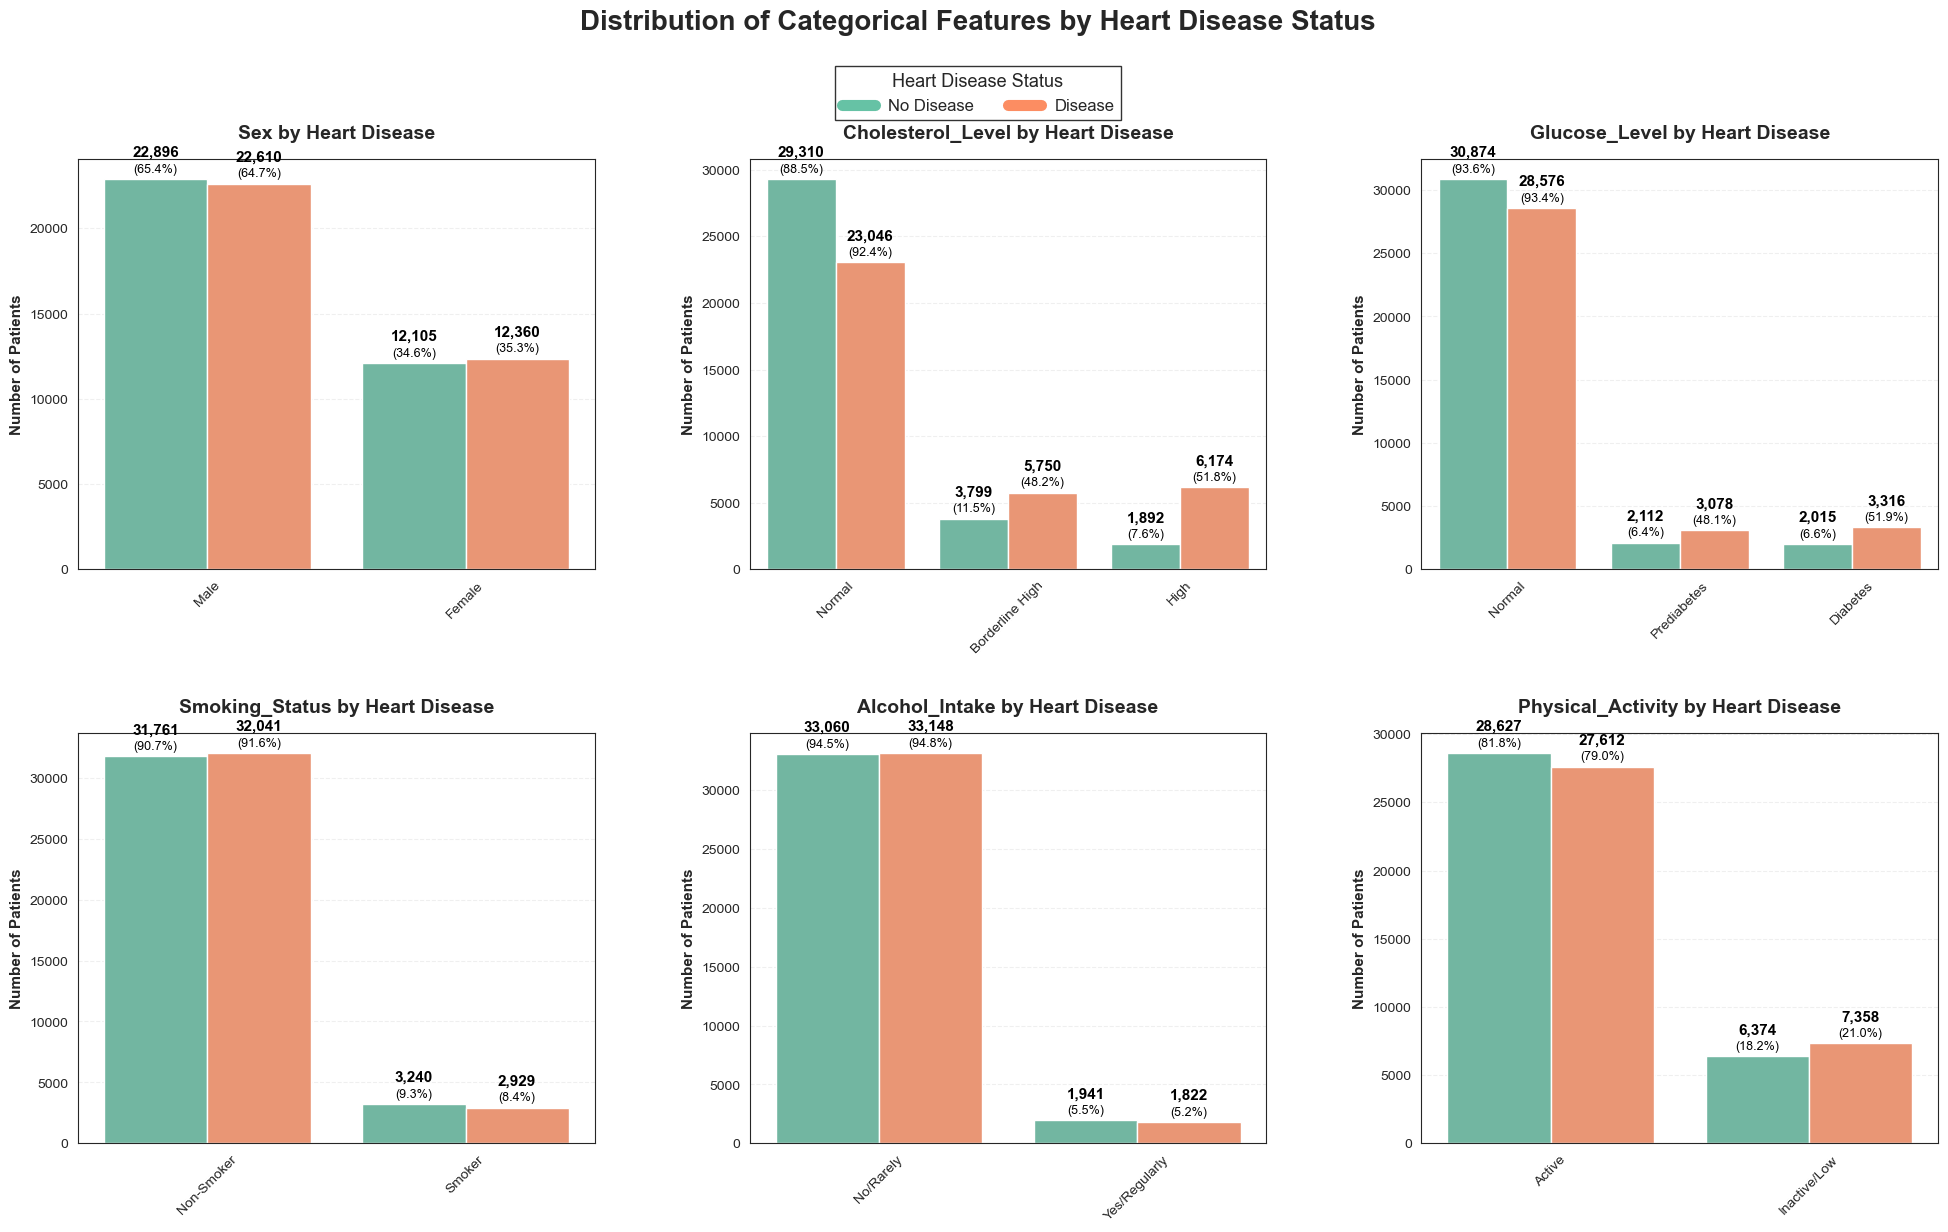

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.lines import Line2D

# ==============================================================
# BIVARIATE: CATEGORICAL FEATURES vs TARGET
# ==============================================================
# Categorical features
cat_cols = [
    'Sex', 'Cholesterol_Level', 'Glucose_Level', 
    'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity'
]

# Manual orders
MANUAL_ORDERS = {
    'Cholesterol_Level': ['Normal', 'Borderline High', 'High'],
    'Glucose_Level': ['Normal', 'Prediabetes', 'Diabetes'],
    'Sex': ['Male', 'Female'],
    'Smoking_Status': ['Non-Smoker', 'Smoker'],
    'Alcohol_Intake': ['No/Rarely', 'Yes/Regularly'],
    'Physical_Activity': ['Active', 'Inactive/Low']
}

# Setup directory
current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'categorical_analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# Layout setup
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
sns.set_style("whitegrid")
axes = axes.flatten()

# Title (at very top)
fig.suptitle('Distribution of Categorical Features by Heart Disease Status',
             fontsize=20, weight='bold', y=0.995)

# Plot each categorical variable
for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    if col not in df.columns:
        continue
    
    # Prepare data
    plot_df = df[[col, 'target']].copy().dropna()
    
    # Map target
    if plot_df['target'].dtype == 'object':
        plot_df['target_name'] = plot_df['target']
    else:
        plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    
    # Determine order
    if col in MANUAL_ORDERS:
        order = [cat for cat in MANUAL_ORDERS[col] if cat in plot_df[col].unique()]
    else:
        if isinstance(plot_df[col].dtype, pd.CategoricalDtype):
            order = list(plot_df[col].cat.categories)
        else:
            try:
                order = sorted(plot_df[col].unique())
            except:
                order = list(plot_df[col].unique())
    
    # Convert numeric to string if needed
    if pd.api.types.is_numeric_dtype(plot_df[col]) and not isinstance(plot_df[col].dtype, pd.CategoricalDtype):
        plot_df[col] = plot_df[col].astype(str)
    
    # Plot
    sns.countplot(
        data=plot_df,
        x=col,
        hue='target_name',
        palette='Set2',
        ax=ax,
        dodge=True,
        legend=False,
        order=order
    )
    
    # Add labels
    patches = ax.patches
    max_height = max([p.get_height() for p in patches]) if patches else 0
    
    for patch_idx, p in enumerate(patches):
        height = p.get_height()
        if height <= 0:
            continue
        
        x_pos = p.get_x() + p.get_width() / 2
        category_idx = patch_idx // 2
        
        if category_idx < len(order):
            category_bars = [patches[category_idx * 2], patches[category_idx * 2 + 1]]
            category_total = sum(bar.get_height() for bar in category_bars)
            percentage = (height / category_total) * 100 if category_total > 0 else 0
        else:
            percentage = 0
        
        # Count (top)
        ax.text(x_pos, height + max_height * 0.05,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=11,
                color='black', fontweight='bold')
        
        # Percentage (below)
        ax.text(x_pos, height + max_height * 0.01,
                f'({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=9,
                color='black')
    
    # Formatting
    ax.set_title(f'{col} by Heart Disease', fontsize=14, pad=15, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Number of Patients', fontsize=11, weight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Legend (moved lower to avoid title overlap)
handles = [
    Line2D([0], [0], color=sns.color_palette('Set2')[0], lw=8, label='No Disease'),
    Line2D([0], [0], color=sns.color_palette('Set2')[1], lw=8, label='Disease')
]
fig.legend(
    handles=handles,
    labels=['No Disease', 'Disease'],
    title='Heart Disease Status',
    loc='upper center',
    bbox_to_anchor=(0.5, 0.955),  # Moved down from 0.965
    ncol=2,
    frameon=True,
    fontsize=12,
    title_fontsize=13,
    edgecolor='black',
    fancybox=False
)

# Adjust layout - more space at top
plt.subplots_adjust(left=0.05, right=0.98, top=0.87, bottom=0.05, hspace=0.4, wspace=0.3)

# Save
img_path = PLOT_DIR / '01_categorical_features_vs_target.png'
plt.savefig(img_path, bbox_inches='tight', dpi=150, facecolor='white')
print(f"✓ Saved: {img_path}")

plt.show()
plt.close()


✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\02_sex_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\02_sex_vs_target.png


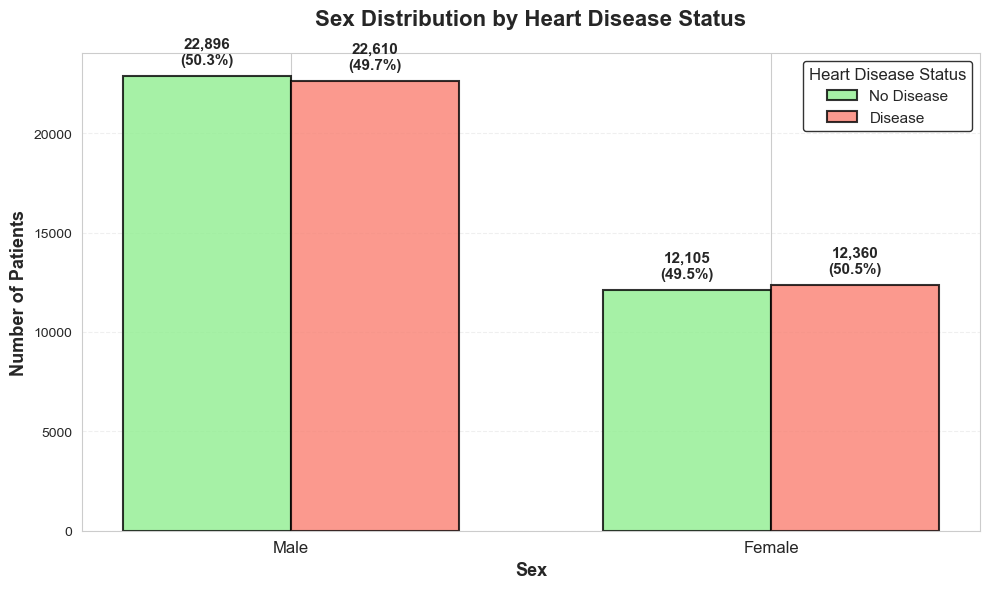

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup directories
current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'categorical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'categorical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

# Feature settings
feature = 'Sex'
order = ['Male', 'Female']
colors_single = ['skyblue', 'lightcoral']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: SEX DISTRIBUTION 
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Sex Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Sex', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '02_sex_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()  # Close without showing

# ==============================================================
# BIVARIATE: SEX vs TARGET
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
sex_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
sex_target_crosstab = sex_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, sex_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, sex_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = sex_target_crosstab.values.max()

for i, sex in enumerate(order):
    sex_total = sex_target_crosstab.loc[sex].sum()
    
    # No Disease bar
    no_disease_count = sex_target_crosstab.loc[sex, no_disease_val]
    no_disease_pct = (no_disease_count / sex_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = sex_target_crosstab.loc[sex, disease_val]
    disease_pct = (disease_count / sex_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Sex Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Sex', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '02_sex_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()  # Show only bivariate
plt.close()

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\03_cholesterol_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\03_cholesterol_vs_target.png


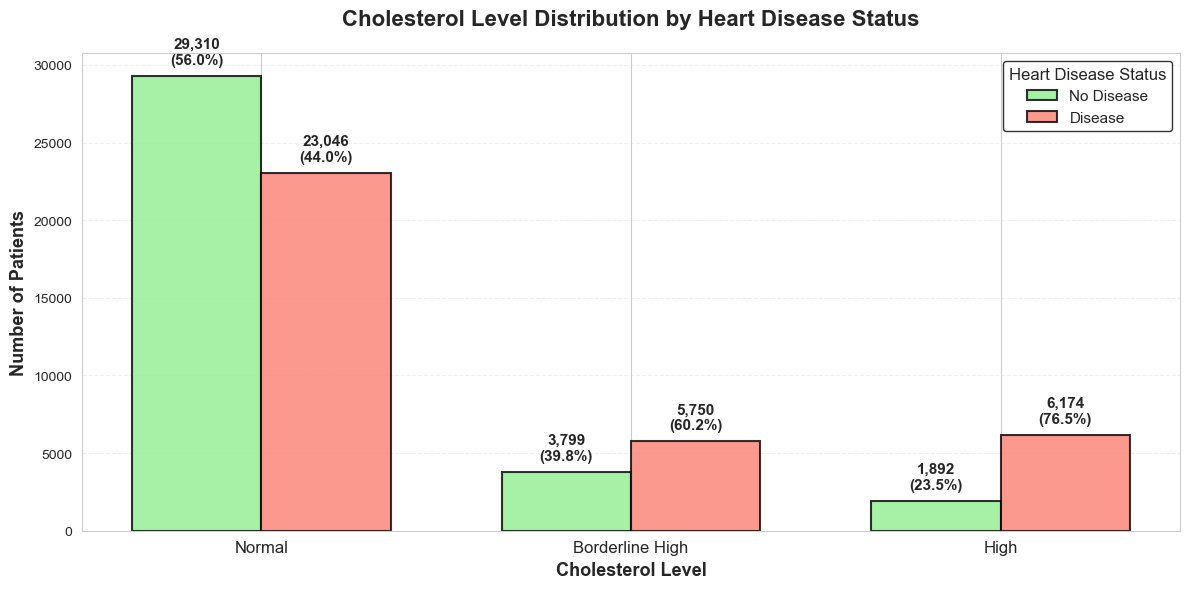

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# Setup directories
current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'categorical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'categorical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

# Feature settings
feature = 'Cholesterol_Level'
order = ['Normal', 'Borderline High', 'High']
colors_single = ['lightgreen', 'gold', 'salmon']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: CHOLESTEROL DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Cholesterol Level Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Cholesterol Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12, rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '03_cholesterol_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: CHOLESTEROL vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(12, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
chol_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
chol_target_crosstab = chol_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, chol_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, chol_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = chol_target_crosstab.values.max()

for i, chol in enumerate(order):
    chol_total = chol_target_crosstab.loc[chol].sum()
    
    # No Disease bar
    no_disease_count = chol_target_crosstab.loc[chol, no_disease_val]
    no_disease_pct = (no_disease_count / chol_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = chol_target_crosstab.loc[chol, disease_val]
    disease_pct = (disease_count / chol_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Cholesterol Level Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Cholesterol Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '03_cholesterol_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\04_glucose_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\04_glucose_vs_target.png


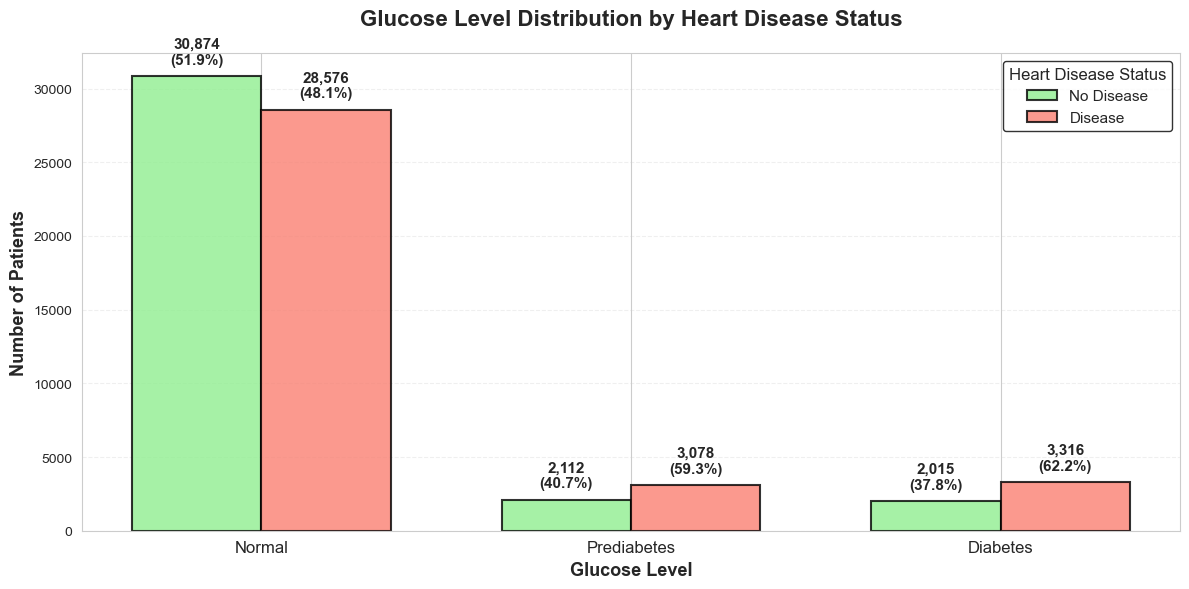

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup directories
current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'categorical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'categorical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

# Feature settings
feature = 'Glucose_Level'
order = ['Normal', 'Prediabetes', 'Diabetes']
colors_single = ['lightgreen', 'gold', 'salmon']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: GLUCOSE DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Glucose Level Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Glucose Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12, rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '04_glucose_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: GLUCOSE vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(12, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
glucose_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
glucose_target_crosstab = glucose_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, glucose_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, glucose_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = glucose_target_crosstab.values.max()

for i, glucose in enumerate(order):
    glucose_total = glucose_target_crosstab.loc[glucose].sum()
    
    # No Disease bar
    no_disease_count = glucose_target_crosstab.loc[glucose, no_disease_val]
    no_disease_pct = (no_disease_count / glucose_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = glucose_target_crosstab.loc[glucose, disease_val]
    disease_pct = (disease_count / glucose_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Glucose Level Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Glucose Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '04_glucose_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\05_smoking_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\05_smoking_vs_target.png


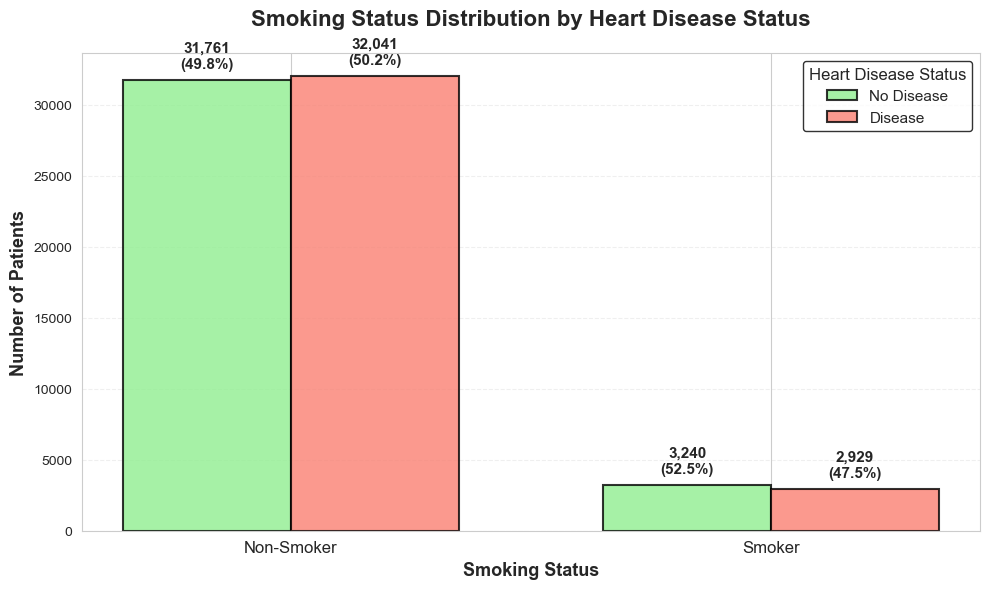

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup directories
current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'categorical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'categorical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

# Feature settings
feature = 'Smoking_Status'
order = ['Non-Smoker', 'Smoker']
colors_single = ['lightgreen', 'lightcoral']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: SMOKING DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Smoking Status Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Smoking Status', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '05_smoking_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: SMOKING vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
smoking_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
smoking_target_crosstab = smoking_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, smoking_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, smoking_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = smoking_target_crosstab.values.max()

for i, smoking in enumerate(order):
    smoking_total = smoking_target_crosstab.loc[smoking].sum()
    
    # No Disease bar
    no_disease_count = smoking_target_crosstab.loc[smoking, no_disease_val]
    no_disease_pct = (no_disease_count / smoking_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = smoking_target_crosstab.loc[smoking, disease_val]
    disease_pct = (disease_count / smoking_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Smoking Status Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Smoking Status', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '05_smoking_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\06_alcohol_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\06_alcohol_vs_target.png


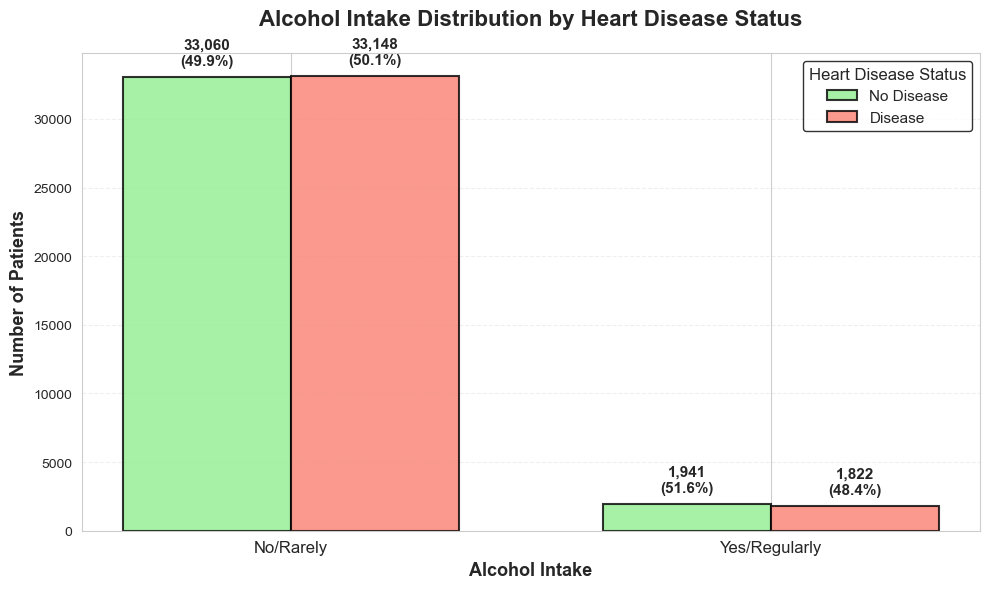

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup directories
current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'categorical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'categorical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

# Feature settings
feature = 'Alcohol_Intake'
order = ['No/Rarely', 'Yes/Regularly']
colors_single = ['lightgreen', 'lightcoral']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: ALCOHOL DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Alcohol Intake Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Alcohol Intake', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '06_alcohol_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: ALCOHOL vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
alcohol_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
alcohol_target_crosstab = alcohol_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, alcohol_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, alcohol_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = alcohol_target_crosstab.values.max()

for i, alcohol in enumerate(order):
    alcohol_total = alcohol_target_crosstab.loc[alcohol].sum()
    
    # No Disease bar
    no_disease_count = alcohol_target_crosstab.loc[alcohol, no_disease_val]
    no_disease_pct = (no_disease_count / alcohol_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = alcohol_target_crosstab.loc[alcohol, disease_val]
    disease_pct = (disease_count / alcohol_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Alcohol Intake Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Alcohol Intake', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '06_alcohol_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\07_physical_activity_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\07_physical_activity_vs_target.png


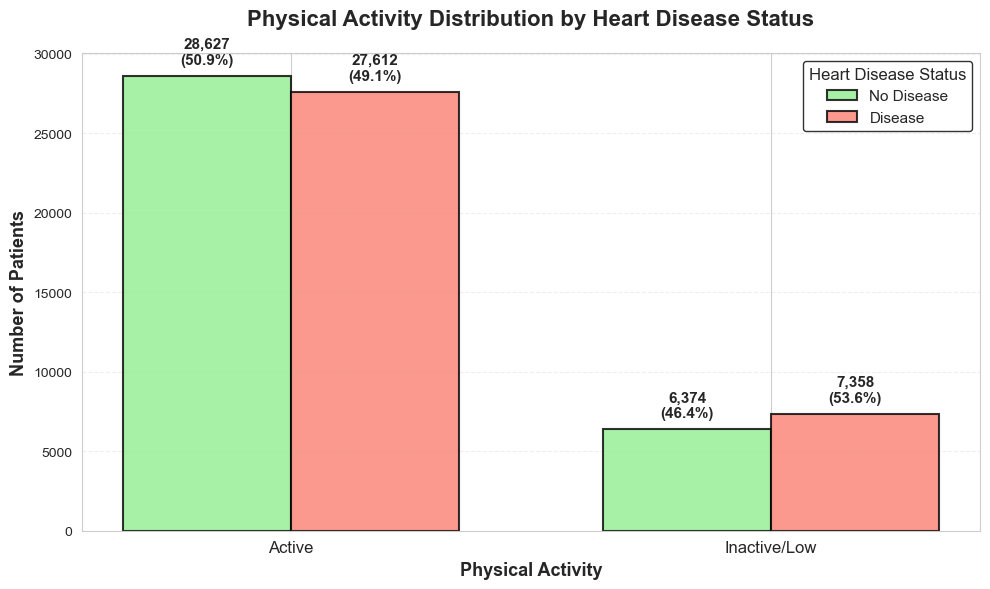

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup directories
current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'categorical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'categorical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

# Feature settings
feature = 'Physical_Activity'
order = ['Active', 'Inactive/Low']
colors_single = ['lightgreen', 'lightcoral']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: PHYSICAL ACTIVITY DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Physical Activity Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Physical Activity', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '07_physical_activity_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: PHYSICAL ACTIVITY vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
activity_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
activity_target_crosstab = activity_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, activity_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, activity_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = activity_target_crosstab.values.max()

for i, activity in enumerate(order):
    activity_total = activity_target_crosstab.loc[activity].sum()
    
    # No Disease bar
    no_disease_count = activity_target_crosstab.loc[activity, no_disease_val]
    no_disease_pct = (no_disease_count / activity_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = activity_target_crosstab.loc[activity, disease_val]
    disease_pct = (disease_count / activity_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Physical Activity Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Physical Activity', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '07_physical_activity_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()


In [32]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

# Categorical features
cat_cols = ['Sex', 'Cholesterol_Level', 'Glucose_Level', 
            'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

print(f"\n✓ Analyzing {len(cat_cols)} categorical features")
print(f"✓ Target distribution: {df['target'].value_counts().to_dict()}")

results = []

# Process each feature
for col in cat_cols:
    if col not in df.columns:
        continue
    
    # Contingency table
    contingency = pd.crosstab(df[col], df['target'])
    chi2, p_value, _, expected = chi2_contingency(contingency)
    cramers_v = association(contingency, method='cramer')
    
    # Effect size
    if cramers_v < 0.1:
        effect = "Negligible"
    elif cramers_v < 0.3:
        effect = "Small"
    elif cramers_v < 0.5:
        effect = "Medium"
    else:
        effect = "Large"
    
    results.append({
        "Feature": col,
        "Chi2": round(chi2, 2),
        "p_value": round(p_value, 4),
        "Cramers_V": round(cramers_v, 4),
        "Effect": effect,
    })

# Results DataFrame
results_df = pd.DataFrame(results).sort_values('Cramers_V', ascending=False)
print(results_df.to_string(index=False))


✓ Analyzing 6 categorical features
✓ Target distribution: {'No Disease': 35001, 'Disease': 34970}
          Feature    Chi2  p_value  Cramers_V     Effect
Cholesterol_Level 3421.23   0.0000     0.2211      Small
    Glucose_Level  586.11   0.0000     0.0915 Negligible
Physical_Activity   88.64   0.0000     0.0356 Negligible
   Smoking_Status   16.78   0.0000     0.0155 Negligible
              Sex    4.41   0.0358     0.0080 Negligible
   Alcohol_Intake    3.80   0.0512     0.0074 Negligible


### Multivariate analysis

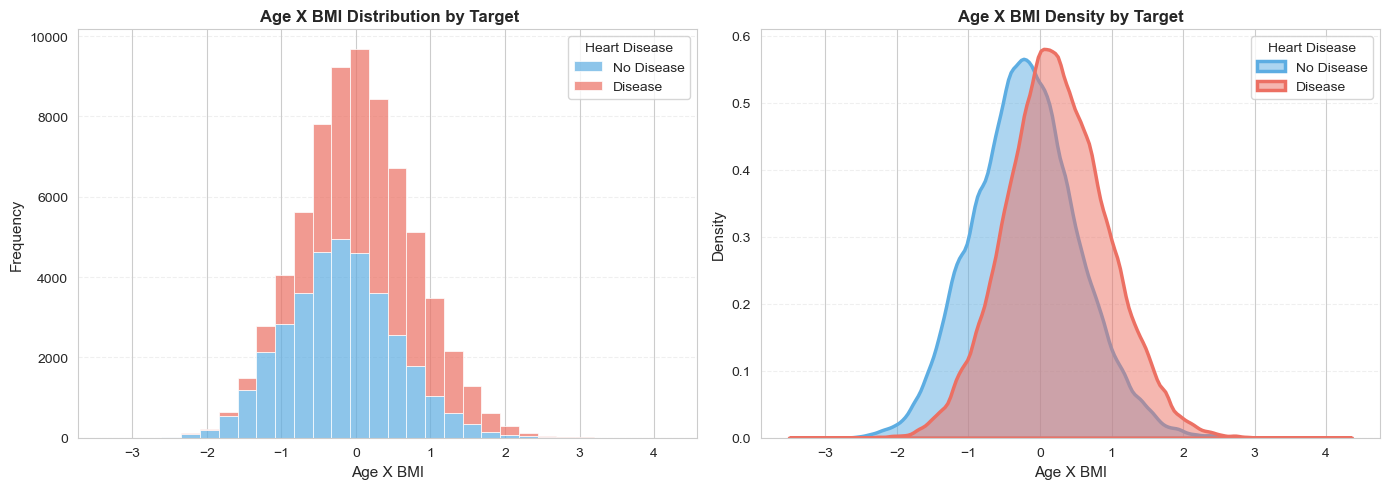

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import RobustScaler

# Setup
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate_analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# Create feature
df['Age_BMI'] = df['Age_Years'] * df['BMI']
df['Age_BMI'] = np.log1p(df['Age_BMI'])
df[['Age_BMI']] = RobustScaler().fit_transform(df[['Age_BMI']])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
target_colors = ['#ec7063', '#5dade2']
hue_order = sorted(df['target'].unique())

sns.histplot(data=df, x='Age_BMI', hue='target', hue_order=hue_order,
             bins=30, stat='count', palette=target_colors, alpha=0.7, edgecolor='white',
             linewidth=0.5, multiple='stack', ax=axes[0])
axes[0].set_title(' Age X BMI Distribution by Target', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Age X BMI', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend(title='Heart Disease', labels=['No Disease', 'Disease'], frameon=True)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

sns.kdeplot(data=df, x='Age_BMI', hue='target', hue_order=hue_order,
            fill=True, palette=target_colors, alpha=0.5, linewidth=2.5, bw_adjust=0.6,
            common_norm=False, ax=axes[1])
axes[1].set_title('Age X BMI Density by Target', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Age X BMI', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].legend(title='Heart Disease', labels=['No Disease', 'Disease'], frameon=True)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(PLOT_DIR / '11_age_bmi_interaction.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


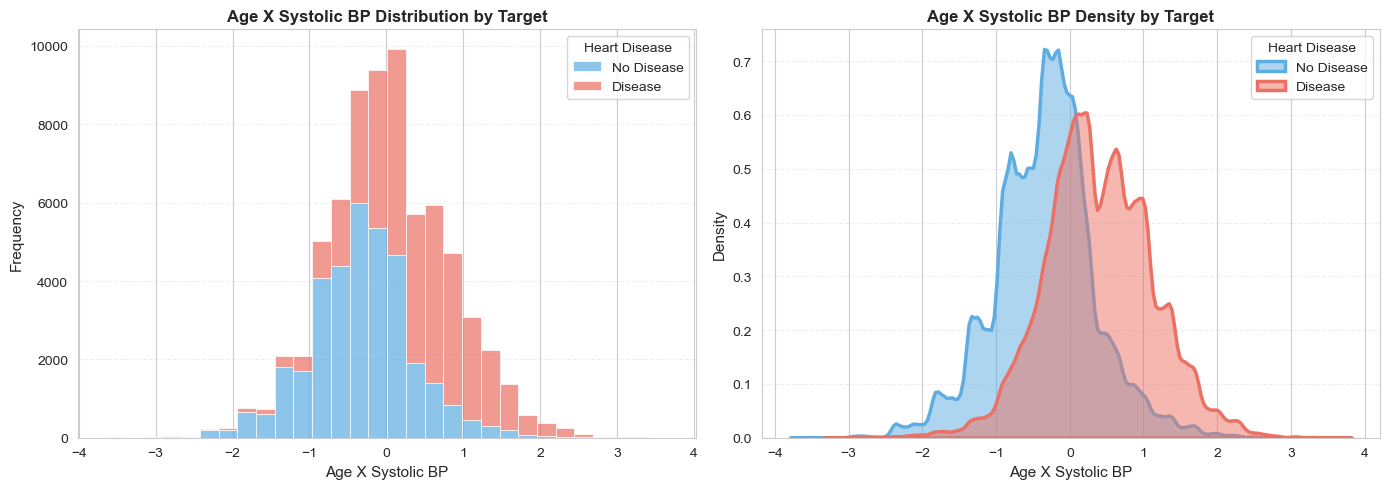

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import RobustScaler

# Setup
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate_analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# Create feature
df['Age_SystolicBP'] = df['Age_Years'] * df['Systolic_BP']**2
df['Age_SystolicBP'] = np.log1p(df['Age_SystolicBP'])
df[['Age_SystolicBP']] = RobustScaler().fit_transform(df[['Age_SystolicBP']])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
target_colors = ['#ec7063', '#5dade2']
hue_order = sorted(df['target'].unique())

sns.histplot(data=df, x='Age_SystolicBP', hue='target', hue_order=hue_order,
             bins=30, stat='count', palette=target_colors, alpha=0.7, edgecolor='white',
             linewidth=0.5, multiple='stack', ax=axes[0])
axes[0].set_title('Age X Systolic BP Distribution by Target', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Age X Systolic BP', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend(title='Heart Disease', labels=['No Disease', 'Disease'], frameon=True)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

sns.kdeplot(data=df, x='Age_SystolicBP', hue='target', hue_order=hue_order,
            fill=True, palette=target_colors, alpha=0.5, linewidth=2.5, bw_adjust=0.6,
            common_norm=False, ax=axes[1])
axes[1].set_title('Age X Systolic BP Density by Target', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Age X Systolic BP', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].legend(title='Heart Disease', labels=['No Disease', 'Disease'], frameon=True)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(PLOT_DIR / '12_age_systolicbp_interaction.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


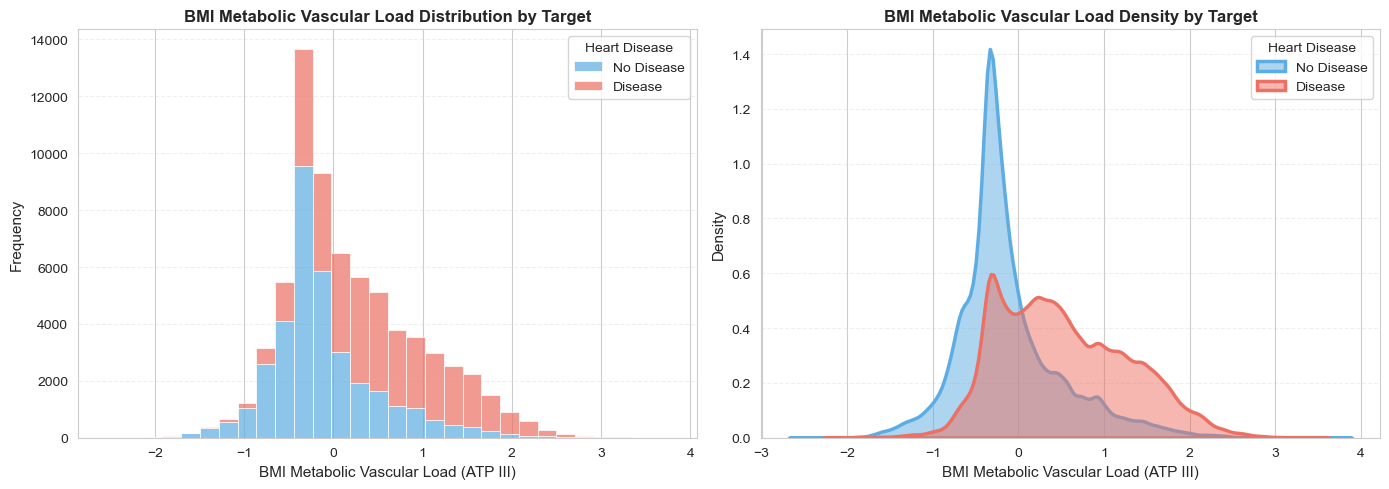

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import RobustScaler

# Setup
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate_analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# ATP III Cholesterol Guidelines Scoring
def cholesterol_risk_score(chol_level):
    """ATP III: Normal (<200) = 1.0, Borderline (200-239) = 2.0, High (≥240) = 3.0"""
    if chol_level == 'Normal':
        return 1.0
    elif chol_level == 'Borderline High':
        return 2.0
    elif chol_level == 'High':
        return 3.0
    else:
        return 1.0

df['Cholesterol_Risk_Score'] = df['Cholesterol_Level'].apply(cholesterol_risk_score)

# Create feature
df['BMI_MetabolicVascularLoad'] = df['BMI'] * (df['Systolic_BP']**2) * df['MAP'] * df['Cholesterol_Risk_Score']
df['BMI_MetabolicVascularLoad'] = np.log1p(df['BMI_MetabolicVascularLoad'])
df[['BMI_MetabolicVascularLoad']] = RobustScaler().fit_transform(df[['BMI_MetabolicVascularLoad']])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
target_colors = ['#ec7063', '#5dade2']
hue_order = sorted(df['target'].unique())

sns.histplot(data=df, x='BMI_MetabolicVascularLoad', hue='target', hue_order=hue_order,
             bins=30, stat='count', palette=target_colors, alpha=0.7, edgecolor='white',
             linewidth=0.5, multiple='stack', ax=axes[0])
axes[0].set_title('BMI Metabolic Vascular Load Distribution by Target', fontsize=12, fontweight='bold')
axes[0].set_xlabel('BMI Metabolic Vascular Load (ATP III)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend(title='Heart Disease', labels=['No Disease', 'Disease'], frameon=True)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

sns.kdeplot(data=df, x='BMI_MetabolicVascularLoad', hue='target', hue_order=hue_order,
            fill=True, palette=target_colors, alpha=0.5, linewidth=2.5, bw_adjust=0.6,
            common_norm=False, ax=axes[1])
axes[1].set_title('BMI Metabolic Vascular Load Density by Target', fontsize=12, fontweight='bold')
axes[1].set_xlabel('BMI Metabolic Vascular Load (ATP III)', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].legend(title='Heart Disease', labels=['No Disease', 'Disease'], frameon=True)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(PLOT_DIR / '13_bmi_metabolic_vascular_load_interaction.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


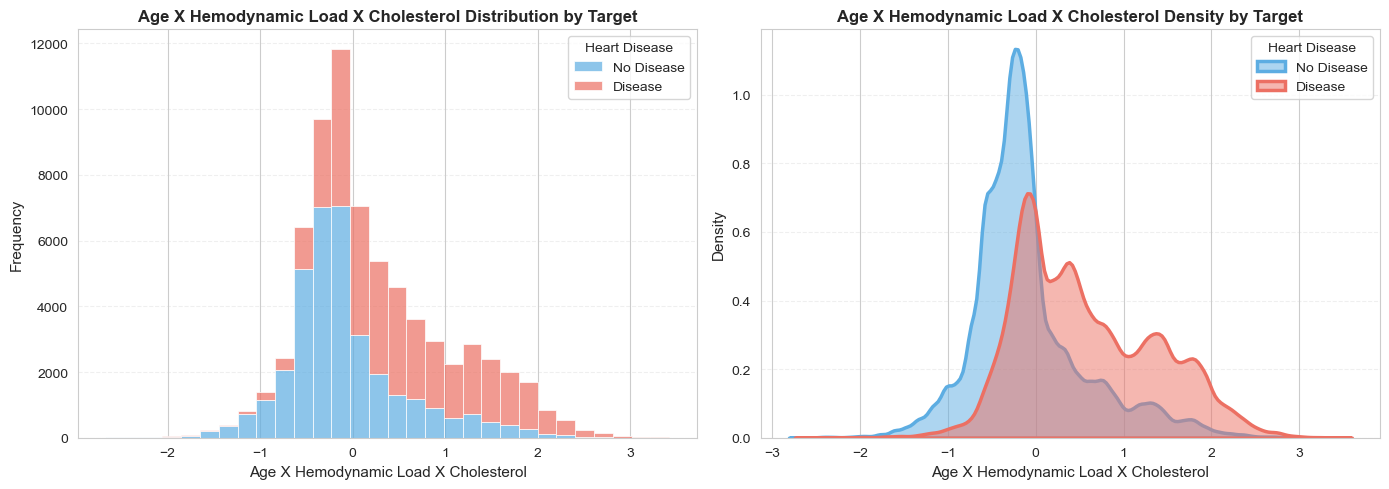

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import RobustScaler

# Setup
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate_analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# Create feature
df['Age_HemodynamicLoad_Chol'] = df['Age_Years'] * df['Pulse_Pressure'] * df['MAP'] * df['Cholesterol_Risk_Score']
df['Age_HemodynamicLoad_Chol'] = np.log1p(df['Age_HemodynamicLoad_Chol'])
df[['Age_HemodynamicLoad_Chol']] = RobustScaler().fit_transform(df[['Age_HemodynamicLoad_Chol']])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
target_colors = ['#ec7063', '#5dade2']
hue_order = sorted(df['target'].unique())

sns.histplot(data=df, x='Age_HemodynamicLoad_Chol', hue='target', hue_order=hue_order,
             bins=30, stat='count', palette=target_colors, alpha=0.7, edgecolor='white',
             linewidth=0.5, multiple='stack', ax=axes[0])
axes[0].set_title('Age X Hemodynamic Load X Cholesterol Distribution by Target', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Age X Hemodynamic Load X Cholesterol', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend(title='Heart Disease', labels=['No Disease', 'Disease'], frameon=True)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

sns.kdeplot(data=df, x='Age_HemodynamicLoad_Chol', hue='target', hue_order=hue_order,
            fill=True, palette=target_colors, alpha=0.5, linewidth=2.5, bw_adjust=0.6,
            common_norm=False, ax=axes[1])
axes[1].set_title('Age X Hemodynamic Load X Cholesterol Density by Target', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Age X Hemodynamic Load X Cholesterol', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].legend(title='Heart Disease', labels=['No Disease', 'Disease'], frameon=True)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(PLOT_DIR / '14_age_hemodynamicload_cholesterol_interaction.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


                  Feature  Point_Biserial  P_value  Mutual_Info  ROC_AUC  Composite
           Age_SystolicBP          0.4540 0.00e+00       0.1249   0.7740     0.2843
BMI_MetabolicVascularLoad          0.4231 0.00e+00       0.1192   0.7551     0.2658
 Age_HemodynamicLoad_Chol          0.4139 0.00e+00       0.1113   0.7573     0.2608
                  Age_BMI          0.2863 0.00e+00       0.0442   0.6654     0.1653


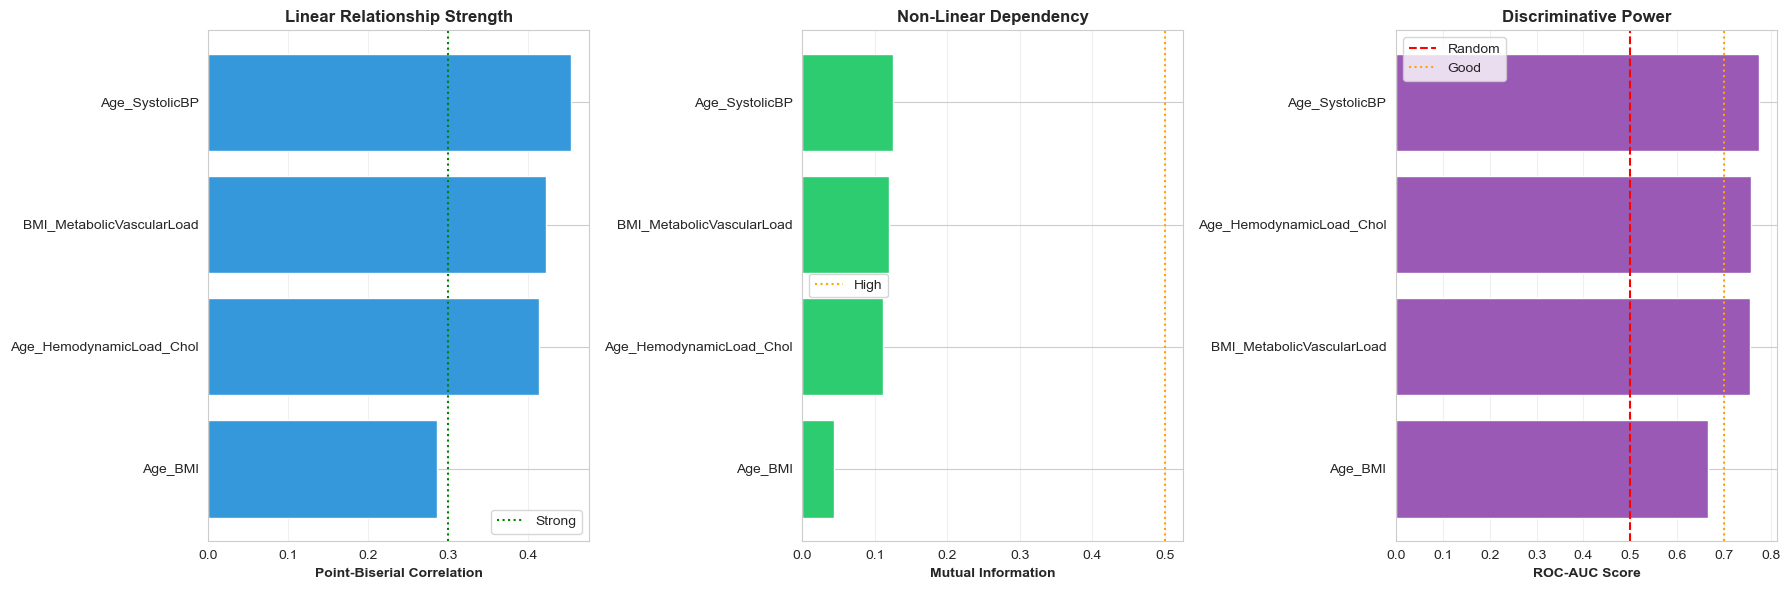

In [37]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Setup
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate_analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# Define features to evaluate
engineered_features = ['Age_SystolicBP','BMI_MetabolicVascularLoad',
                       'Age_HemodynamicLoad_Chol','Age_BMI']

def evaluate_features(df, features, target='target'):
    """Evaluate features using 3 statistical tests"""
    
    # Convert target to binary
    label_map = {'No Disease': 0, 'Disease': 1}
    y = df[target].map(label_map).values
    
    results = []
    for feature in features:
        if feature not in df.columns:
            print(f"⚠️ {feature} not found. Skipping...")
            continue
        
        # Get feature values
        X = df[feature].values
        
        # Calculate metrics
        r_pb, p_val = pointbiserialr(y, X)
        mi = mutual_info_classif(X.reshape(-1, 1), y, random_state=42)[0]
        auc = roc_auc_score(y, X)
        auc = max(auc, 1 - auc)
        composite = (abs(r_pb) + mi + (auc - 0.5)) / 3
        
        results.append({
            'Feature': feature,
            'Point_Biserial': round(r_pb, 4),
            'P_value': f'{p_val:.2e}',
            'Mutual_Info': round(mi, 4),
            'ROC_AUC': round(auc, 4),
            'Composite': round(composite, 4)
        })
    
    return pd.DataFrame(results).sort_values('Composite', ascending=False)

# Evaluate features
results_df = evaluate_features(df, engineered_features)
print(results_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Point-Biserial
df_sorted = results_df.sort_values('Point_Biserial')
axes[0].barh(df_sorted['Feature'], df_sorted['Point_Biserial'], color='#3498db')
axes[0].set_xlabel('Point-Biserial Correlation', fontweight='bold')
axes[0].set_title('Linear Relationship Strength', fontweight='bold')
axes[0].axvline(x=0.3, color='green', linestyle=':', label='Strong')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Mutual Information
df_sorted = results_df.sort_values('Mutual_Info')
axes[1].barh(df_sorted['Feature'], df_sorted['Mutual_Info'], color='#2ecc71')
axes[1].set_xlabel('Mutual Information', fontweight='bold')
axes[1].set_title('Non-Linear Dependency', fontweight='bold')
axes[1].axvline(x=0.5, color='orange', linestyle=':', label='High')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

# Plot 3: ROC-AUC
df_sorted = results_df.sort_values('ROC_AUC')
axes[2].barh(df_sorted['Feature'], df_sorted['ROC_AUC'], color='#9b59b6')
axes[2].set_xlabel('ROC-AUC Score', fontweight='bold')
axes[2].set_title('Discriminative Power', fontweight='bold')
axes[2].axvline(x=0.5, color='red', linestyle='--', label='Random')
axes[2].axvline(x=0.7, color='orange', linestyle=':', label='Good')
axes[2].legend()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_DIR / '15_feature_evaluation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [38]:
# dropping cholesterol_risk_score and age_bmi due to its less prediction power
df = df.drop(columns=['Cholesterol_Risk_Score', 'Age_BMI'])

In [39]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Suppress divide by zero warnings (expected for perfectly correlated features)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Define features
raw_features = ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP', 'Pulse_Pressure', 'MAP']
engineered_features = ['Age_SystolicBP', 'BMI_MetabolicVascularLoad', 'Age_HemodynamicLoad_Chol']

def calculate_vif(df, features):
    """Calculate VIF for given features"""
    vif_data = []
    df_subset = df[features].values
    
    for i, feature in enumerate(features):
        vif = variance_inflation_factor(df_subset, i)
        
        # Handle infinity values
        if np.isinf(vif):
            vif_display = "inf"
            status = "Perfect collinearity"
        elif vif > 10:
            vif_display = round(vif, 2)
            status = " High"
        elif vif > 5:
            vif_display = round(vif, 2)
            status = "Moderate"
        else:
            vif_display = round(vif, 2)
            status = "Low"
        
        vif_data.append({
            'Feature': feature, 
            'VIF': vif_display,
            'Status': status
        })
    
    return pd.DataFrame(vif_data).sort_values(
        'VIF', 
        ascending=False, 
        key=lambda x: x.replace('inf', '999999').astype(float)
    )

# Calculate VIF
print("\n📊 RAW FEATURES VIF:")
print(calculate_vif(df, raw_features).to_string(index=False))

print("\n" + "-"*75)

print("\n📊 ENGINEERED FEATURES VIF:")
print(calculate_vif(df, engineered_features).to_string(index=False))

print("\n" + "-"*75)

print("\n📊 COMBINED VIF:")
print(calculate_vif(df, raw_features + engineered_features).to_string(index=False))


📊 RAW FEATURES VIF:
       Feature    VIF               Status
   Systolic_BP    inf Perfect collinearity
  Diastolic_BP    inf Perfect collinearity
Pulse_Pressure    inf Perfect collinearity
           MAP    inf Perfect collinearity
     Age_Years  44.61                 High
           BMI  29.15                 High

---------------------------------------------------------------------------

📊 ENGINEERED FEATURES VIF:
                  Feature  VIF   Status
 Age_HemodynamicLoad_Chol 7.15 Moderate
BMI_MetabolicVascularLoad 6.48 Moderate
           Age_SystolicBP 2.16      Low

---------------------------------------------------------------------------

📊 COMBINED VIF:
                  Feature     VIF               Status
              Systolic_BP     inf Perfect collinearity
             Diastolic_BP     inf Perfect collinearity
           Pulse_Pressure     inf Perfect collinearity
                      MAP     inf Perfect collinearity
                Age_Years   623.1           

Due to veryhigh multinearity raw features will be dropped, its grouped features will be kept for modeling in order to improve the interpretability and explanability of the model

In [40]:
# raw features will be dropped from the dataset after
columns_to_drop = ['Age_Years', 'BMI', 'Systolic_BP', 'MAP', 'Pulse_Pressure', 'Diastolic_BP']
df = df.drop(columns=columns_to_drop)

In [41]:
df.columns

Index(['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
       'Alcohol_Intake', 'Physical_Activity', 'target', 'Age_Group',
       'BP_Group', 'PP_Group', 'MAP_Group', 'BMI_Group', 'Age_SystolicBP',
       'BMI_MetabolicVascularLoad', 'Age_HemodynamicLoad_Chol'],
      dtype='object')

In [42]:
cols = ['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
       'Alcohol_Intake', 'Physical_Activity', 'target', 'Age_Group',
       'BP_Group', 'PP_Group', 'MAP_Group', 'BMI_Group']
# print all unique values in each categorical column
for col in cols:
    unique_values = df[col].unique()
    print(f"{col}: {unique_values}")

Sex: ['Female' 'Male']
Cholesterol_Level: ['Normal' 'High' 'Borderline High']
Glucose_Level: ['Normal' 'Prediabetes' 'Diabetes']
Smoking_Status: ['Non-Smoker' 'Smoker']
Alcohol_Intake: ['No/Rarely' 'Yes/Regularly']
Physical_Activity: ['Active' 'Inactive/Low']
target: ['No Disease' 'Disease']
Age_Group: ['50-54', '55-59', '45-49', '60-64', '40-44', '<40']
Categories (8, object): ['<40' < '40-44' < '45-49' < '50-54' < '55-59' < '60-64' < '65-69' < '70+']
BP_Group: ['Stage 1 Hypertension', 'Stage 2+ Hypertension', 'Normal', 'Elevated']
Categories (4, object): ['Normal' < 'Elevated' < 'Stage 1 Hypertension' < 'Stage 2+ Hypertension']
PP_Group: ['Low (<40)', 'Normal (40-60)', 'High (>60)']
Categories (3, object): ['Low (<40)' < 'Normal (40-60)' < 'High (>60)']
MAP_Group: ['Low (<93)', 'Elevated (100-110)', 'High (>110)', 'Normal (93-100)']
Categories (4, object): ['Low (<93)' < 'Normal (93-100)' < 'Elevated (100-110)' < 'High (>110)']
BMI_Group: ['Normal/Underweight', 'Obese I', 'Overweight

In [43]:
import pandas as pd
import numpy as np

# ============================================================================
# ENCODING SCRIPT WITH ORDINAL CONVERSION FIRST
# ============================================================================

print("🔄 Starting Encoding with Ordinal Conversion...\n")

# ============================================================================
# STEP 1: CONVERT TO ORDERED CATEGORICAL (Critical for proper encoding)
# ============================================================================
print("STEP 1: Converting to Ordered Categorical")
print("="*70)

# Define ordinal categories with proper order
ordinal_categories = {
    'Age_Group': ['<40', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70+'],
    'BMI_Group': ['Normal/Underweight', 'Overweight', 'Obese I', 'Obese II/III'],
    'BP_Group': ['Normal', 'Elevated', 'Stage 1 Hypertension', 'Stage 2+ Hypertension'],
    'PP_Group': ['Low (<40)', 'Normal (40-60)', 'High (>60)'],
    'MAP_Group': ['Low (<93)', 'Normal (93-100)', 'Elevated (100-110)', 'High (>110)'],
    'Cholesterol_Level': ['Normal', 'Borderline High', 'High'],
    'Glucose_Level': ['Normal', 'Prediabetes', 'Diabetes']
}

# Convert to ordered categorical
for col, categories in ordinal_categories.items():
    if col in df.columns:
        df[col] = pd.Categorical(df[col], categories=categories, ordered=True)
        print(f"✅ {col:25s}: Ordered categorical with {len(categories)} levels")

print()

# ============================================================================
# STEP 2: ENCODE TARGET (0/1)
# ============================================================================
print("STEP 2: Encoding Target Variable")
print("="*70)

df['target'] = df['target'].map({'No Disease': 0, 'Disease': 1}).fillna(0).astype('int8')
print(f"✅ Target: {df['target'].value_counts().to_dict()}\n")

# ============================================================================
# STEP 3: ENCODE ORDINAL FEATURES (Using cat.codes + 1)
# ============================================================================
print("STEP 3: Encoding Ordinal Features")
print("="*70)

for col in ordinal_categories.keys():
    if col in df.columns:
        # Use cat.codes (0-indexed) and add 1 to make it 1-indexed
        df[col] = df[col].cat.codes + 1
        df[col] = df[col].astype('int8')
        print(f"✅ {col:25s}: {sorted(df[col].unique())}")

print()

# ============================================================================
# STEP 4: ENCODE BINARY/NOMINAL FEATURES
# ============================================================================
print("STEP 4: Encoding Binary/Nominal Features")
print("="*70)

nominal_mappings = {
    'Sex': {'Female': 1, 'Male': 2},
    'Smoking_Status': {'Non-Smoker': 1, 'Smoker': 2},
    'Alcohol_Intake': {'No/Rarely': 1, 'Yes/Regularly': 2},
    'Physical_Activity': {'Active': 1, 'Inactive/Low': 2}
}

for col, mapping in nominal_mappings.items():
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].map(mapping).fillna(1).astype('int8')
        print(f"✅ {col:25s}: {sorted(df[col].unique())}")

print()

# ============================================================================
# STEP 5: VERIFICATION
# ============================================================================
print("STEP 5: Verification")
print("="*70)

all_encoded_cols = list(ordinal_categories.keys()) + list(nominal_mappings.keys())
encoded_cols_present = [col for col in all_encoded_cols if col in df.columns]

# Check all features start from 1
all_valid = all(df[col].min() == 1 for col in encoded_cols_present)

# Check target is 0/1
target_valid = set(df['target'].unique()) == {0, 1}

print(f"\n📊 Summary:")
print(f"   Ordinal features: {len([c for c in ordinal_categories.keys() if c in df.columns])}")
print(f"   Nominal features: {len([c for c in nominal_mappings.keys() if c in df.columns])}")
print(f"   Total encoded: {len(encoded_cols_present)}")
print(f"   Shape: {df.shape}")

print(f"\n🔍 Validation:")
if all_valid and target_valid:
    print("   ✅ All features start from 1")
    print("   ✅ Target is 0/1")
    print("\n🎉 ENCODING SUCCESSFUL - READY FOR MODELING!")
else:
    print("   ⚠️  Some issues detected - check above")

print("\n" + "="*70)

🔄 Starting Encoding with Ordinal Conversion...

STEP 1: Converting to Ordered Categorical
✅ Age_Group                : Ordered categorical with 8 levels
✅ BMI_Group                : Ordered categorical with 4 levels
✅ BP_Group                 : Ordered categorical with 4 levels
✅ PP_Group                 : Ordered categorical with 3 levels
✅ MAP_Group                : Ordered categorical with 4 levels
✅ Cholesterol_Level        : Ordered categorical with 3 levels
✅ Glucose_Level            : Ordered categorical with 3 levels

STEP 2: Encoding Target Variable
✅ Target: {0: 35001, 1: 34970}

STEP 3: Encoding Ordinal Features
✅ Age_Group                : [1, 2, 3, 4, 5, 6]
✅ BMI_Group                : [1, 2, 3, 4]
✅ BP_Group                 : [1, 2, 3, 4]
✅ PP_Group                 : [1, 2, 3]
✅ MAP_Group                : [1, 2, 3, 4]
✅ Cholesterol_Level        : [1, 2, 3]
✅ Glucose_Level            : [1, 2, 3]

STEP 4: Encoding Binary/Nominal Features
✅ Sex                      : [1, 2]


In [44]:
from pathlib import Path

# Navigate to project root
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

# Create path and save
OUTPUT_FILE = PROJECT_ROOT / 'data' / 'processed' / 'processed_data.parquet'
OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)

# Save to parquet
df.to_parquet(OUTPUT_FILE, engine='pyarrow', compression='snappy', index=False)

# Verify
print(f"✅ Saved to: {OUTPUT_FILE}")
print(f"📊 Size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")
print(f"📊 Shape: {df.shape}")

✅ Saved to: p:\projects\heart_disease_prediction\data\processed\processed_data.parquet
📊 Size: 1.46 MB
📊 Shape: (69971, 15)
